In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import glob
import pandas as pd
import peakutils
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
filenames = sorted(glob.glob('../messdaten/calib/*'))
filenames1 = sorted(glob.glob('../messdaten/calib_data/*'))

In [3]:
def genY(filenames):
    """
    Reads out the true dosage from the header of a csv file.
    Returns Numpy Array of dosages.
    filenames : 1D Array
        List of filenames to be read out.
    """
    Y = []
    for file in filenames:
        with open(file, 'r') as f:
            dosage = f.readlines()[3]
            dosage = dosage.split()[1]
            dosage = float(dosage[6:])
            Y.append(dosage)
    return np.array(Y)

In [4]:
def readFromTxt(filenames):
    return [np.genfromtxt(filename, skip_header=7, skip_footer=1).T for filename in filenames]

In [5]:
def gaussian(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

def window(x, n):
    return (x[(n-1):] + x[:-(n-1)])/float(n)
xFrame = pd.DataFrame(columns = ['Peak1Center', 'Peak1Amplitude', 'Peak1Width',
                                 'Peak2Center', 'Peak2Amplitude', 'Peak2Width',
                                 'Peak3Center', 'Peak3Amplitude', 'Peak3Width',
                                 'Peak4Center', 'Peak4Amplitude', 'Peak4Width',
                                 'Peak1AreaRaw', 'Peak2AreaRaw', 'Peak3AreaRaw', 'Peak4AreaRaw',
                                 'Peak1AreaFit','Peak2AreaFit', 'Peak3AreaFit', 'Peak4AreaFit',
                                 'HeatingStart', 'HeatingEnd', 'TotalHitsRaw', 'TotalHitsFit',
                                 'HitsPreHeatingFirstRaw', 'HitsPreHeatingSecondRaw', 
                                 'HitsPostHeatingFirstRaw', 'HistPostHeatingSecondRaw', 
                                 'HitsDuringHeatingRaw', 'HitsDuringHeatingFit', 
                                 'MeanHitsPreHeatingRaw', 'MeanHitsPostHeatingRaw',
                                 'MeanFitDeviation'
                                 ])

In [6]:

#with PdfPages('multipage_pdf3.pdf') as pdf:
def genAttributes(filenames):
    xVals = []
    arrays = readFromTxt(filenames)
    t = 0 
    for datas in arrays:
        t +=1
        timemask = (datas[0] > 0.5) & (datas[0] < 9.0)
        times = datas[0]
        temps = datas[1]
        hits = datas[2]
        
        maxima = argrelextrema(hits[(times > 0.5) & (times < 9.0)], np.greater, order=25)
        minima = argrelextrema(hits, np.less)
        maxima = peakutils.indexes(hits, min_dist=40, thres=0.7)
        
        # get heat start point
        for i in range(80,300):
            if np.mean(hits[:70] )*7.5 < np.mean(hits[i:i+30]):
                preHeat = i
                ##plt.vlines(times[i], 0, np.max(hits))
                break 
                
        # get heat end point
        for i in range(500,900)[::-1]:
            if np.mean(hits[i-40:i] )> 7*np.mean(hits[900:]):
                postHeat = i
                #print(np.mean(times[i-40:i] ))
                ##plt.vlines(times[i], 0, np.max(hits))
                break
                
        meanHitsPreHeat = np.mean(hits[0:preHeat])/preHeat
        meanHitsPostHeat = np.mean(hits[postHeat:])/(len(hits)-postHeat)
        binSumPreHeat = np.sum(hits[0:preHeat])
        binSumPreHeatFirst = np.sum(hits[0:preHeat//2])
        binSumPreHeatSecond = np.sum(hits[preHeat//2:preHeat])
        binSumPostHeatFirst = np.sum(hits[postHeat:(len(hits)-postHeat)//2])
        binSumPostHeatSecond = np.sum(hits[(len(hits)-postHeat)//2:])
        binSumHeating = np.sum(hits[preHeat:postHeat])
        
        #binSumPreHeatMinusPre = np.sum(datas[2][0:preHeat]- meanHitsPreHeat)
        #binSumPostHeatMinusPre = np.sum(datas[2][postHeat:]- meanHitsPreHeat)
        #binSumHeatingMinusPre = np.sum(datas[2][preHeat:postHeat]- meanHitsPreHeat)
        #binSumPreHeatMinusPost = np.sum(datas[2][0:preHeat]- meanHitsPostHeat)
        #binSumPostHeatMinusPost = np.sum(datas[2][postHeat:]- meanHitsPostHeat)
        #binSumHeatingMinusPost = np.sum(datas[2][preHeat:postHeat]- meanHitsPostHeat)
        heatTimeMask = (times > preHeat) & (times < postHeat)
        
        # gaussian fit
        try:
            d = times[maxima[1]] - times[maxima[0]]
            guess = [times[maxima[0]], hits[maxima[0]], 0.1, 
                 times[maxima[1]], hits[maxima[1]], 0.1,
                 times[maxima[1]]+d, hits[maxima[1]]*0.75, 0.1,
                 times[maxima[1]]+2*d, hits[maxima[1]]*0.65, 0.1]
        except:
            guess = [1, 10, 0.1,
                     2, 10, 0.1,
                     3, 10, 0.1,
                     4, 10, 0.1]
        
        popt, pcov = curve_fit(gaussian, times, hits, p0=guess, maxfev=30000)
        #print(popt)
        fit = gaussian(times, *popt)
        ##plt.plot(times, fit , 'r-') 
        meanFitDeviation = np.mean(np.abs(fit - hits))
        
        #peak features
        popt = np.split(popt, 4)
        # ctr amp wid
        popt = (np.array(popt).T)
        def peakArea(ctr, wid):
            timemask = (times> ctr-wid/2) & (times < ctr+wid/2)
            return np.sum(hits[timemask])
        
        peakAreasRaw = [peakArea(popt[0][0], popt[2][0]), 
                     peakArea(popt[0][1], popt[2][1]),
                     peakArea(popt[0][2], popt[2][2]),
                     peakArea(popt[0][3], popt[2][3])]
        
        def gaus(x, ctr, amp, wid):
            return amp * np.exp( -((x - ctr)/wid)**2)
        gausses = [gaus(times, popt[0][0], popt[1][0], popt[2][0]),
                   gaus(times, popt[0][1], popt[1][1], popt[2][1]),
                   gaus(times, popt[0][2], popt[1][2], popt[2][2]),
                   gaus(times, popt[0][3], popt[1][3], popt[2][3])]
        peakAreasFit = np.sum(gausses, axis=1) 
        
        
       
        #print(chisquare(f_obs=fit[heatTimeMask], f_exp=hits[heatTimeMask] ))
        #plt.vlines(popt[0][3]-popt[2][3], 0, np.max(hits))
        #plt.vlines(popt[0][3]+popt[2][3], 0, np.max(hits))
                
            
            
        #for i in maxima:
        #    plt.vlines(datas[0][i], 0, np.max(datas[2]))
        #print(maxima)
    
        ##plt.plot(times, hits, 'x', markersize=1.5)
        ##plt.xlabel('Zeit / s')
        ##plt.ylabel('Counts')
        ##pdf.savefig()
        ##plt.close()
        
        # moving average
        countsMoav = 0.5*(hits[1:] + hits[:-1])
#        plt.plot(times[1:], countsMoav, 'x', markersize=1.5)
#        plt.xlabel('Zeit / s')
#        plt.ylabel('Counts')
#        pdf.savefig()
#        plt.close()
        
        
        # fourier transform
        #fft = np.fft.fft(hits)
        #counts1, bins, _ = plt.hist(fft, range=(-2000, 0), bins=15)
        #counts2, bins, _ = plt.hist(fft, range=(0, 2000), bins=15)
        #counts = counts1[::-1] + counts2
        #bins = window(bins, 2)
        #freqMean = np.mean(fft)
        #freqStd = np.std(fft)
        #freq90perc = np.percentile(fft, 90)
        #plt.plot(bins, counts)
        #pdf.savefig()
        #plt.close()
        
        
        #plt.plot(datas[0][100:end], 
        #         np.fft.ifft(np.fft.fft(datas[2])[100:end]), 'x', markersize=1)
        #plt.vlines(datas[0][500], 0, np.max(datas[2]))
        #pdf.savefig()
        #plt.close()
        
        hitsDuringHeatingFit = np.sum(fit[timemask])
        binSumPreHeatFit = np.sum(fit[:preHeat])
        binSumPostHeatFit = np.sum(fit[postHeat:])
        totalHitsFit = hitsDuringHeatingFit + binSumPostHeatFit + binSumPreHeatFit
        
        xVals.append([popt[0][0], popt[1][0], popt[2][0], 
                      popt[0][1], popt[1][1], popt[2][1], 
                      popt[0][2], popt[1][2], popt[2][2], 
                      popt[0][3], popt[1][3], popt[2][3], 
                      peakAreasRaw[0], peakAreasRaw[1],
                      peakAreasRaw[2], peakAreasRaw[3],
                      peakAreasFit[0], peakAreasFit[1],
                      peakAreasFit[2], peakAreasFit[3],
                      times[preHeat], times[postHeat],
                      np.sum(hits), totalHitsFit,
                      binSumPreHeatFirst, binSumPreHeatSecond,
                      binSumPostHeatFirst, binSumPostHeatSecond, binSumHeating,
                      hitsDuringHeatingFit, meanHitsPreHeat, meanHitsPostHeat,
                      meanFitDeviation])
        print(t,filenames[t-1],'one more')

    xFrame = pd.DataFrame(xVals, columns = ['Peak1Center', 'Peak1Amplitude', 'Peak1Width',
                                 'Peak2Center', 'Peak2Amplitude', 'Peak2Width',
                                 'Peak3Center', 'Peak3Amplitude', 'Peak3Width',
                                 'Peak4Center', 'Peak4Amplitude', 'Peak4Width',
                                 'Peak1AreaRaw', 'Peak2AreaRaw', 'Peak3AreaRaw', 'Peak4AreaRaw',
                                 'Peak1AreaFit','Peak2AreaFit', 'Peak3AreaFit', 'Peak4AreaFit',
                                 'HeatingStart', 'HeatingEnd', 'TotalHitsRaw', 'TotalHitsFit',
                                 'HitsPreHeatingFirstRaw', 'HitsPreHeatingSecondRaw', 
                                 'HitsPostHeatingFirstRaw', 'HistPostHeatingSecondRaw', 
                                 'HitsDuringHeatingRaw', 'HitsDuringHeatingFit', 
                                 'MeanHitsPreHeatingRaw', 'MeanHitsPostHeatingRaw',
                                 'MeanFitDeviation'
                       ])
    return xFrame

In [8]:
Xnew = genAttributes(filenames)
Ynew = genY(filenames)

1 ../messdaten/calib/R1408305_2015-10-14-001.txt one more
2 ../messdaten/calib/R1408305_2015-10-14-002.txt one more
3 ../messdaten/calib/R1408305_2015-10-14-003.txt one more
4 ../messdaten/calib/R1408305_2015-10-15-006.txt one more
5 ../messdaten/calib/R1408305_2015-10-15-008.txt one more
6 ../messdaten/calib/R1408305_2015-10-15-009.txt one more
7 ../messdaten/calib/R1408305_2015-10-16-001.txt one more
8 ../messdaten/calib/R1408305_2015-10-21-011.txt one more
9 ../messdaten/calib/R1408305_2015-10-21-013.txt one more
10 ../messdaten/calib/R1408305_2015-10-22-008.txt one more
11 ../messdaten/calib/R1408305_2015-10-26-005.txt one more
12 ../messdaten/calib/R1408305_2015-10-26-007.txt one more
13 ../messdaten/calib/R1408305_2015-10-26-009.txt one more
14 ../messdaten/calib/R1408305_2015-10-27-002.txt one more
15 ../messdaten/calib/R1408305_2015-10-27-004.txt one more
16 ../messdaten/calib/R1408305_2015-10-27-006.txt one more
17 ../messdaten/calib/R1408305_2015-10-27-008.txt one more
18 ../

In [9]:
Ynew

array([  5. ,   5. ,   1. ,   1. ,   1. ,   1. ,   1. ,   3. ,   3. ,
         3. ,  10. ,  10. ,  10. ,  10. ,   0.4,   0.4,   0.4,   5. ,
         5. ,   1. ,   1. ,   1. ,   1. ,   1. ,   3. ,   3. ,   3. ,
        10. ,  10. ,  10. ,  10. ,   0.4,   0.4,   0.4])

In [10]:
unknown = sorted(glob.glob('../messdaten/unknown/*'))
Xunknown = genAttributes(unknown)

1 ../messdaten/unknown/R1408303_2015-10-14-001.txt one more
2 ../messdaten/unknown/R1408303_2015-10-14-002.txt one more
3 ../messdaten/unknown/R1408303_2015-10-16-002.txt one more
4 ../messdaten/unknown/R1408303_2015-10-16-006.txt one more
5 ../messdaten/unknown/R1408303_2015-10-20-009.txt one more
6 ../messdaten/unknown/R1408303_2015-10-20-012.txt one more
7 ../messdaten/unknown/R1408303_2015-10-20-014.txt one more
8 ../messdaten/unknown/R1408303_2015-10-21-007.txt one more
9 ../messdaten/unknown/R1408305_2016-01-04-001.txt one more
10 ../messdaten/unknown/R1408306_2015-10-22-005.txt one more
11 ../messdaten/unknown/R1409101_2016-08-17-004.txt one more


In [11]:
X = genAttributes(filenames1)
Y = genY(filenames1)

1 ../messdaten/calib_data/R1406801_2015-10-14-001.txt one more
2 ../messdaten/calib_data/R1406801_2015-10-14-002.txt one more
3 ../messdaten/calib_data/R1406802_2015-10-14-001.txt one more
4 ../messdaten/calib_data/R1406802_2015-10-14-002.txt one more
5 ../messdaten/calib_data/R1406802_2015-10-14-005.txt one more
6 ../messdaten/calib_data/R1406802_2015-10-15-006.txt one more
7 ../messdaten/calib_data/R1406802_2015-10-15-008.txt one more
8 ../messdaten/calib_data/R1406802_2015-10-15-009.txt one more
9 ../messdaten/calib_data/R1406802_2015-10-16-001.txt one more
10 ../messdaten/calib_data/R1406802_2015-10-16-006.txt one more
11 ../messdaten/calib_data/R1406802_2015-10-20-009.txt one more
12 ../messdaten/calib_data/R1406802_2015-10-20-012.txt one more
13 ../messdaten/calib_data/R1406802_2015-10-20-014.txt one more
14 ../messdaten/calib_data/R1406802_2015-10-21-007.txt one more
15 ../messdaten/calib_data/R1406802_2015-10-21-011.txt one more
16 ../messdaten/calib_data/R1406802_2015-10-22-00

/home/fongo/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


110 ../messdaten/calib_data/R1406805_2015-11-04-004.txt one more
111 ../messdaten/calib_data/R1406805_2015-11-04-006.txt one more
112 ../messdaten/calib_data/R1406805_2015-11-05-006.txt one more
113 ../messdaten/calib_data/R1406805_2015-11-05-008.txt one more
114 ../messdaten/calib_data/R1406805_2015-11-16-002.txt one more
115 ../messdaten/calib_data/R1406805_2015-11-19-010.txt one more
116 ../messdaten/calib_data/R1406806_2015-10-14-001.txt one more
117 ../messdaten/calib_data/R1406806_2015-10-14-002.txt one more
118 ../messdaten/calib_data/R1406806_2015-10-14-005.txt one more
119 ../messdaten/calib_data/R1406806_2015-10-15-006.txt one more
120 ../messdaten/calib_data/R1406806_2015-10-15-008.txt one more
121 ../messdaten/calib_data/R1406806_2015-10-15-009.txt one more
122 ../messdaten/calib_data/R1406806_2015-10-16-001.txt one more
123 ../messdaten/calib_data/R1406806_2015-10-16-002.txt one more
124 ../messdaten/calib_data/R1406806_2015-10-16-006.txt one more
125 ../messdaten/calib_da

/home/fongo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/fongo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


507 ../messdaten/calib_data/R1407305_2015-10-21-011.txt one more
508 ../messdaten/calib_data/R1407305_2015-10-21-013.txt one more
509 ../messdaten/calib_data/R1407305_2015-10-22-008.txt one more
510 ../messdaten/calib_data/R1407305_2015-10-23-002.txt one more
511 ../messdaten/calib_data/R1407305_2015-10-23-004.txt one more
512 ../messdaten/calib_data/R1407305_2015-10-26-005.txt one more
513 ../messdaten/calib_data/R1407305_2015-10-26-009.txt one more
514 ../messdaten/calib_data/R1407305_2015-10-27-002.txt one more
515 ../messdaten/calib_data/R1407305_2015-10-27-006.txt one more
516 ../messdaten/calib_data/R1407305_2015-10-27-008.txt one more
517 ../messdaten/calib_data/R1407305_2015-10-30-001.txt one more
518 ../messdaten/calib_data/R1407305_2015-10-30-003.txt one more
519 ../messdaten/calib_data/R1407305_2015-11-02-004.txt one more
520 ../messdaten/calib_data/R1407305_2015-11-02-006.txt one more
521 ../messdaten/calib_data/R1407305_2015-11-03-009.txt one more
522 ../messdaten/calib_da

In [12]:
blacklist = ['Peak1Center', 'Peak1AreaFit', 
            'Peak2AreaFit', 
            'HitsDuringHeatingRaw',
            'Peak3Amplitude', 
            'MeanFitDeviation',
            'HitsDuringHeatingFit',
            'HistPostHeatingSecondRaw']

In [13]:
print(X.corr() > 0.9)

                         Peak1Center Peak1Amplitude Peak1Width Peak2Center  \
Peak1Center                     True          False       True       False   
Peak1Amplitude                 False           True      False       False   
Peak1Width                      True          False       True       False   
Peak2Center                    False          False      False        True   
Peak2Amplitude                 False          False      False       False   
Peak2Width                     False          False      False       False   
Peak3Center                    False          False      False       False   
Peak3Amplitude                 False          False      False       False   
Peak3Width                     False          False      False       False   
Peak4Center                    False          False      False       False   
Peak4Amplitude                 False          False      False       False   
Peak4Width                     False          False      False  

In [14]:
with PdfPages('multipage_pdf3.pdf') as pdf:
    for attr in X.columns:
        if attr in blacklist:
            continue
        binRange = (np.percentile(X[attr], 2),np.percentile(X[attr], 98))
        #plt.hist(X[attr][Y == 10.0], bins=25, alpha=0.5 ,
        #     range=binRange, normed=True, label='10.0 mSv')
        plt.hist(X[attr][Y == 5.0], bins=25, alpha=0.5, 
             range=binRange, normed=True, label='5.0 mSv')
        plt.hist(X[attr][Y == 4.0], bins=25, alpha=0.5, 
             range=binRange, normed=True, label='4.0 mSv')
        plt.xlabel(attr)
        plt.legend(loc='best')
        pdf.savefig()
        plt.close()

In [15]:
from collections import Counter
Counter(Y)

Counter({0.050000000000000003: 58,
         0.059999999999999998: 81,
         0.070000000000000007: 81,
         0.080000000000000002: 78,
         0.089999999999999997: 82,
         0.10000000000000001: 83,
         0.20000000000000001: 85,
         0.29999999999999999: 91,
         0.40000000000000002: 92,
         0.5: 68,
         1.0: 66,
         2.0: 70,
         3.0: 94,
         4.0: 91,
         5.0: 212,
         10.0: 94})

## Random Forest Regression ##

In [18]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.model_selection import cross_val_predict

In [19]:
rforest = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=2, )
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=0)
sklearn.model_selection.cross_val_predict
rforest.fit(X_train, y_train)
predictions = rforest.predict(X_test)

In [20]:
cpredictions = cross_val_predict(rforest, X, Y, cv=5, n_jobs=2)

In [21]:
len(cpredictions)

1426

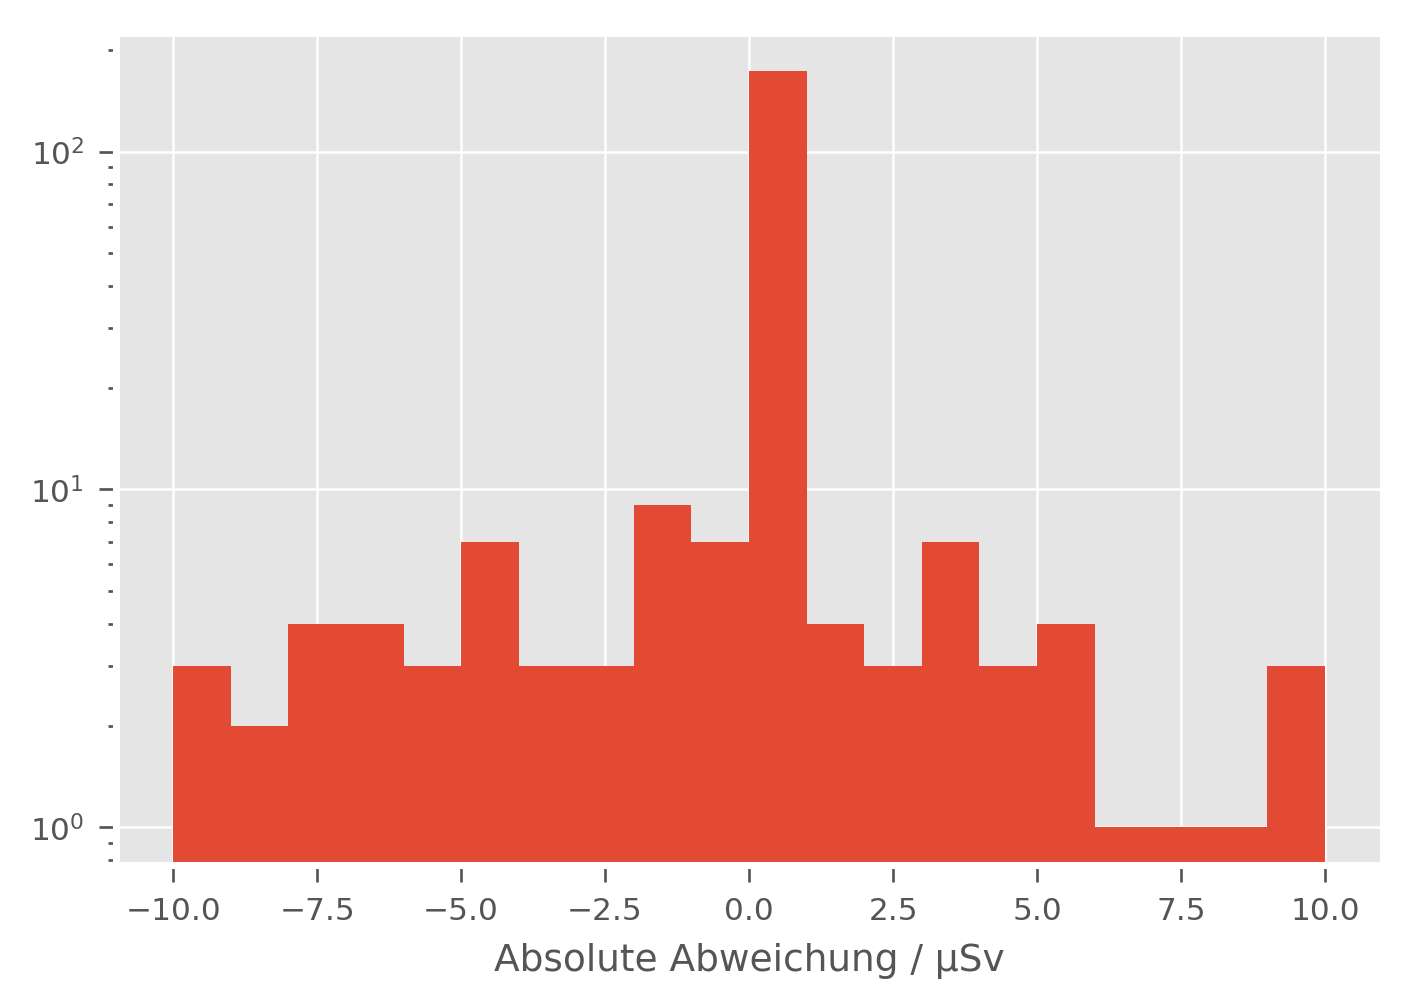

In [22]:
relDiff = ((predictions-y_test)/y_test)
absDiff = ((predictions-y_test))
absDiff *= 1000
#plt.hist(relDiff, bins=20, range=(-0.2,0.2) )
plt.hist(absDiff, bins=20, range=(-0.01*1000,0.01*1000) )
np.mean(np.abs(relDiff-0.00))
plt.yscale('log')
plt.xlabel('Absolute Abweichung / µSv')
fig = plt.gcf()
fig.set_figheight(3.6)
fig.get_figheight
plt.savefig('./absAbweichung.pdf')

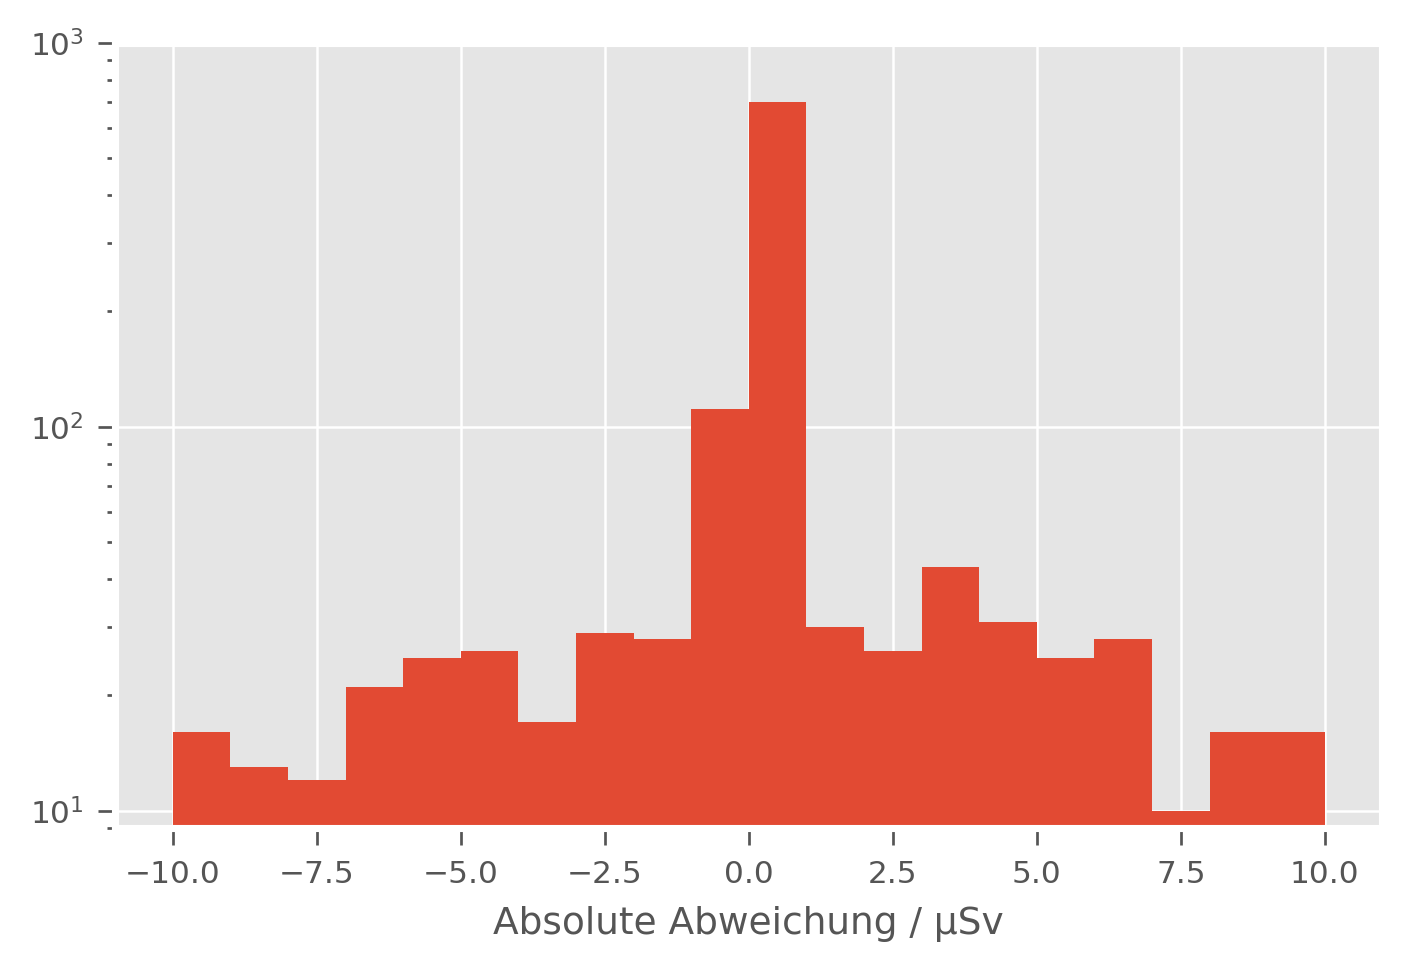

In [23]:
relDiff = ((cpredictions-Y)/Y)
absDiff = ((cpredictions-Y))
absDiff *= 1000
#plt.hist(relDiff, bins=20, range=(-0.2,0.2) )
plt.hist(absDiff, bins=20, range=(-0.01*1000,0.01*1000) )
np.mean(np.abs(relDiff-0.00))
fig = plt.gcf()
fig.set_figheight(3.4)
fig.get_figheight
plt.yscale('log')
plt.ylim(9,1000)
plt.xlabel('Absolute Abweichung / µSv')
plt.savefig('./absAbweichung.pdf')

In [24]:
np.corrcoef(predictions, y_test)

array([[ 1.        ,  0.99972871],
       [ 0.99972871,  1.        ]])

(array([  1.,  31.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.004 , -0.0011,  0.0018,  0.0047,  0.0076,  0.0105,  0.0134,
         0.0163,  0.0192,  0.0221,  0.025 ,  0.0279,  0.0308,  0.0337,
         0.0366,  0.0395,  0.0424,  0.0453,  0.0482,  0.0511,  0.054 ]),
 <a list of 20 Patch objects>)

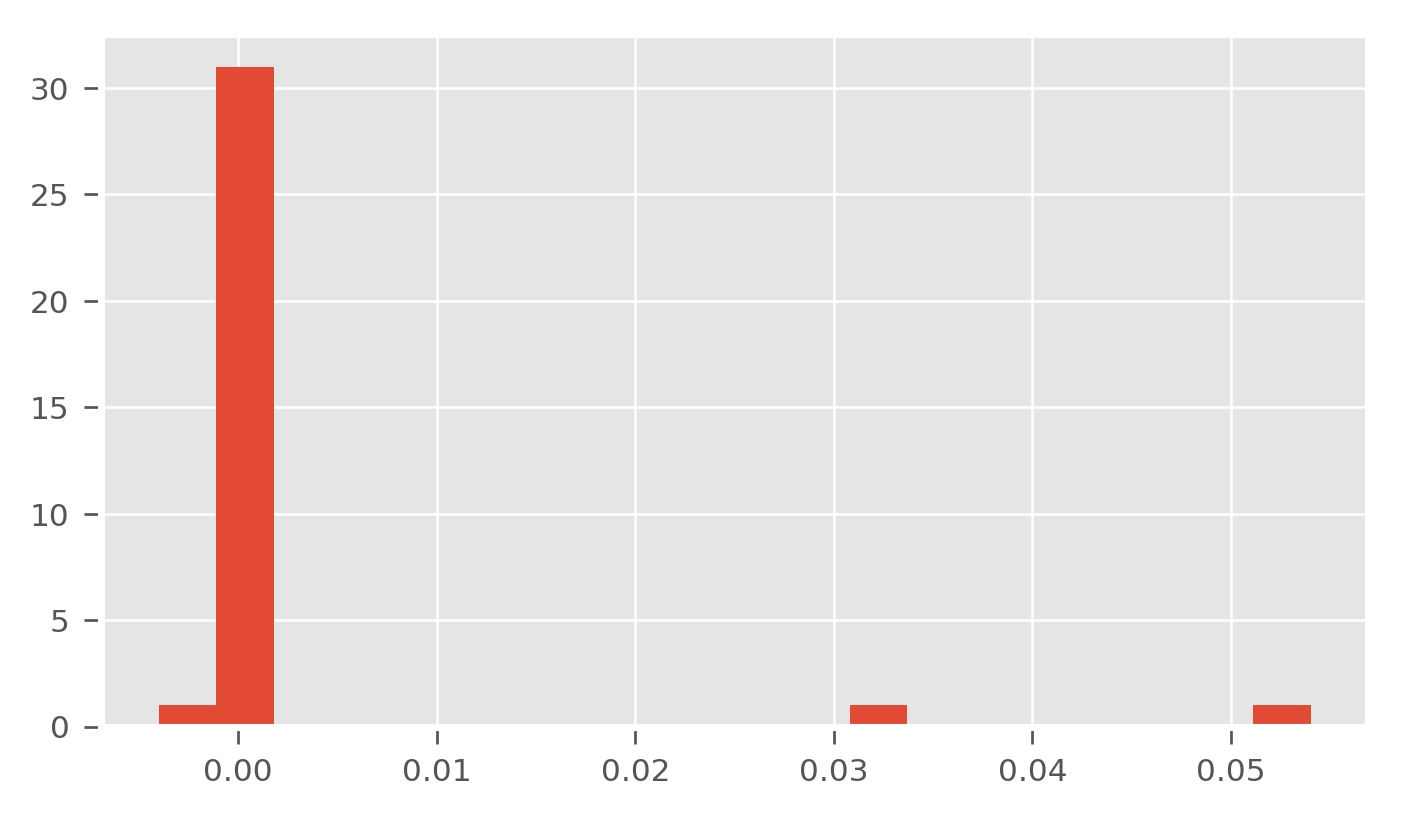

In [25]:
predNew = rforest.predict(Xnew)
reldiffNew = (predNew - Ynew)/Ynew
plt.hist(reldiffNew, bins=20)

In [26]:
predU = rforest.predict(Xunknown)
for name,pred in zip(unknown, predU):
    print(name+', Dosage:',pred)

../messdaten/unknown/R1408303_2015-10-14-001.txt, Dosage: 5.0
../messdaten/unknown/R1408303_2015-10-14-002.txt, Dosage: 5.0
../messdaten/unknown/R1408303_2015-10-16-002.txt, Dosage: 2.0
../messdaten/unknown/R1408303_2015-10-16-006.txt, Dosage: 2.0
../messdaten/unknown/R1408303_2015-10-20-009.txt, Dosage: 2.0
../messdaten/unknown/R1408303_2015-10-20-012.txt, Dosage: 2.0
../messdaten/unknown/R1408303_2015-10-20-014.txt, Dosage: 2.0
../messdaten/unknown/R1408303_2015-10-21-007.txt, Dosage: 2.0
../messdaten/unknown/R1408305_2016-01-04-001.txt, Dosage: 0.05002
../messdaten/unknown/R1408306_2015-10-22-005.txt, Dosage: 5.926
../messdaten/unknown/R1409101_2016-08-17-004.txt, Dosage: 1.764


In [27]:
Xunknown

,Peak1Center,Peak1Amplitude,Peak1Width,Peak2Center,Peak2Amplitude,Peak2Width,Peak3Center,Peak3Amplitude,Peak3Width,Peak4Center,...,TotalHitsFit,HitsPreHeatingFirstRaw,HitsPreHeatingSecondRaw,HitsPostHeatingFirstRaw,HistPostHeatingSecondRaw,HitsDuringHeatingRaw,HitsDuringHeatingFit,MeanHitsPreHeatingRaw,MeanHitsPostHeatingRaw,MeanFitDeviation
0,2.478855,1012.411605,0.338459,3.249545,670.915244,0.335601,3.939602,788.103300,0.694526,5.048049,...,255610.922007,34.0,23.0,0.0,203687.0,257684.0,255599.989298,0.004544,0.005449,10.504963
1,2.590045,862.864149,0.357335,3.414860,638.524524,0.370689,4.164957,652.758916,0.675819,5.346447,...,235678.965400,31.0,21.0,0.0,216303.0,237356.0,235656.748202,0.003552,0.005575,10.171075
2,2.497879,378.360142,0.353439,3.299272,251.452097,0.353349,3.993965,276.822964,0.705292,5.207926,...,99143.678641,37.0,17.0,0.0,82883.0,99725.0,99119.225415,0.003099,0.002810,5.804715
3,2.435474,382.457707,0.335232,3.221493,262.155991,0.358603,3.888569,278.057651,0.670280,5.020060,...,96975.406573,27.0,15.0,0.0,76692.0,97632.0,96960.116427,0.002646,0.002634,5.820961
4,2.490108,358.651659,0.353106,3.270396,231.987554,0.329042,3.910456,279.469941,0.717228,5.091566,...,95295.231376,35.0,33.0,0.0,77700.0,95963.0,95280.600488,0.004150,0.002309,5.517917
5,2.420906,419.726365,0.340760,3.181112,279.282180,0.331511,3.826266,314.133570,0.668596,4.951056,...,105549.188864,22.0,14.0,0.0,81115.0,106209.0,105524.712681,0.002819,0.002848,5.658764
6,2.488290,422.583602,0.357887,3.290447,279.091218,0.341185,3.959862,291.120058,0.688287,5.141042,...,106693.646132,27.0,24.0,0.0,87187.0,107409.0,106674.267540,0.003371,0.002815,6.030174
7,2.370771,397.684848,0.335455,3.114346,308.762140,0.332471,3.779588,320.584045,0.624229,4.838534,...,103012.192186,31.0,26.0,0.0,76990.0,103600.0,102991.872127,0.003707,0.003107,5.583922
8,3.526445,2.190087,0.802349,4.359389,1.871529,0.205041,5.203393,2.025435,0.847784,10.662712,...,1312.074282,25.0,6.0,0.0,1043.0,827.0,987.217258,0.002016,0.000914,0.741392
9,3.939201,765.629185,1.054798,4.626666,74.747709,0.192806,4.970462,159.420800,0.340567,5.793340,...,216675.329497,34.0,41.0,0.0,217835.0,217498.0,216558.998742,0.003246,0.006042,16.557899


In [28]:
# plot mit trennkraft der attribute
fourattrs = ['MeanHitsPostHeatingRaw', 'MeanHitsPreHeatingRaw', 'Peak2Amplitude',
             'TotalHitsRaw']

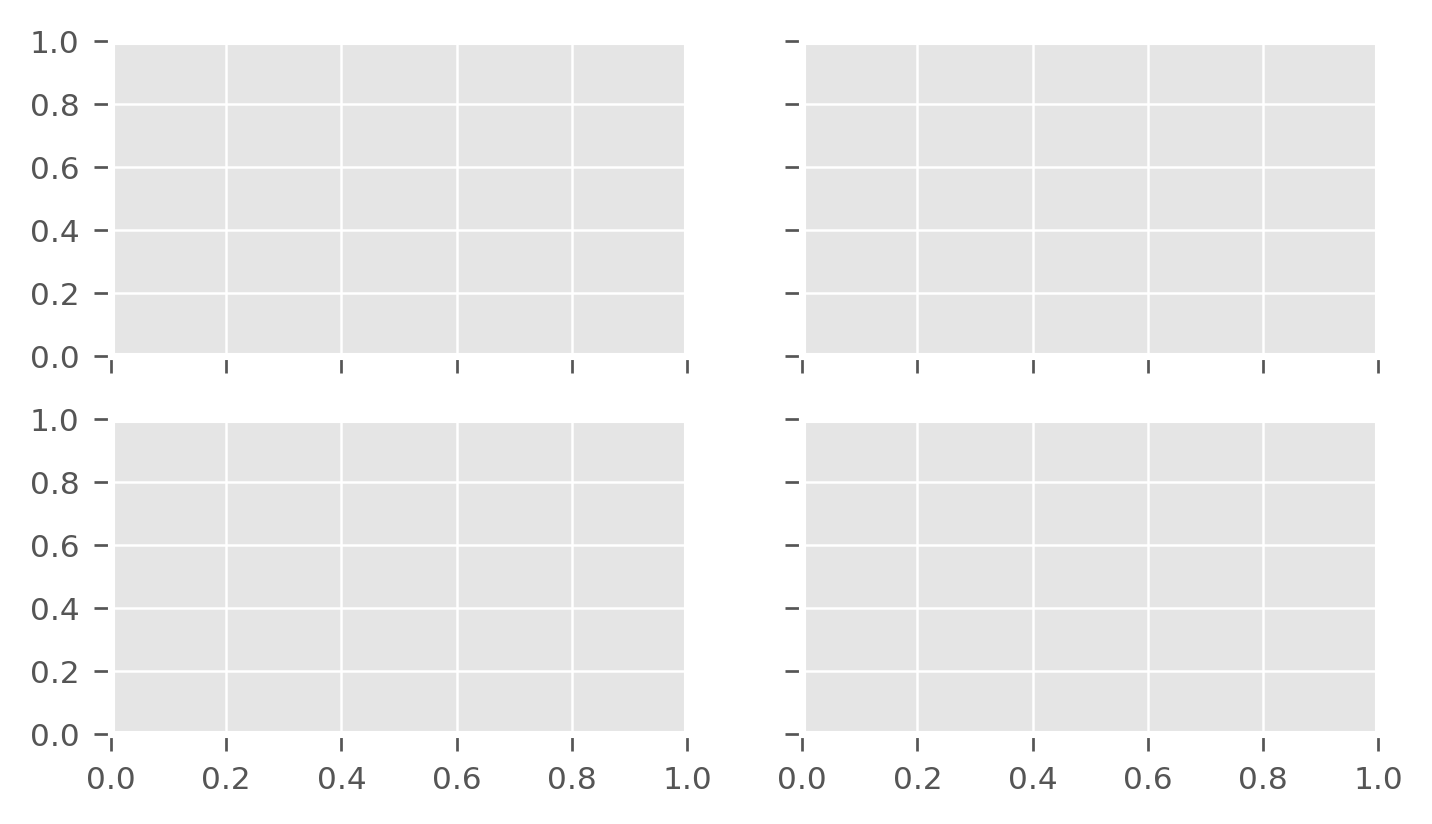

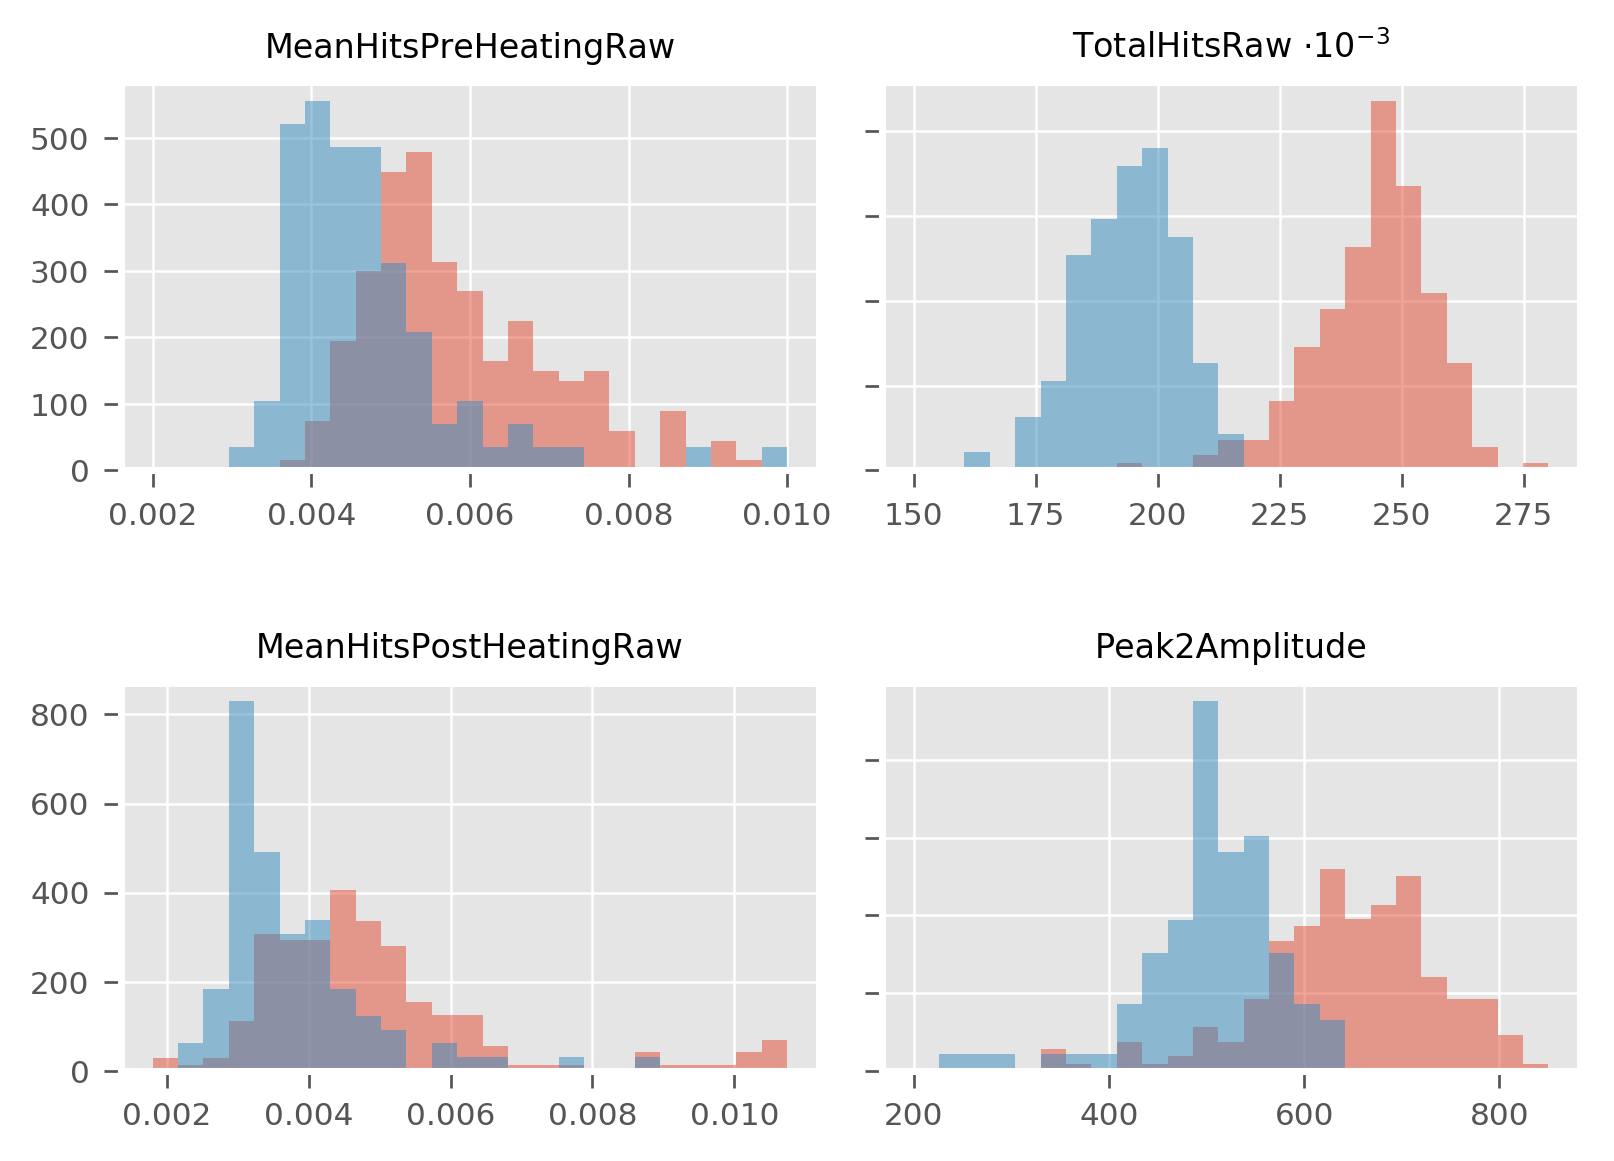

In [29]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
length4 = len(X['TotalHitsRaw'][Y == 4.0])
length5 = len(X['TotalHitsRaw'][Y == 5.0])
normed = True
histtype='bar'
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)




binRange = (np.percentile(X['TotalHitsRaw'], 2), 
            np.percentile(X['TotalHitsRaw'], 98))
binRange=(150000, 280000)
binRange=(150, 280)
ax2.hist(np.nan_to_num(X['TotalHitsRaw'][Y == 5.0])/1000, bins=25, alpha=0.5, 
         range=binRange, normed=True, histtype=histtype,
         label='5.0 mSv')
ax2.hist(np.nan_to_num(X['TotalHitsRaw'][Y == 4.0])/1000, bins=25, alpha=0.5, 
         range=binRange, normed=True, histtype=histtype,
         label='4.0 mSv')

binRange = (np.percentile(X['Peak2Amplitude'], 2), 
            np.percentile(X['Peak2Amplitude'], 98))
binRange=(200, 850)
ax4.hist(np.nan_to_num(X['Peak2Amplitude'][Y == 5.0]), bins=25, alpha=0.5, 
         range=binRange, normed=True, histtype=histtype,
         label='5.0 mSv')
ax4.hist(np.nan_to_num(X['Peak2Amplitude'][Y == 4.0]), bins=25, alpha=0.5, 
         range=binRange, normed=True, histtype=histtype,
         label='4.0 mSv')

binRange = (np.percentile(X['MeanHitsPostHeatingRaw'], 2), 
            np.percentile(X['MeanHitsPostHeatingRaw'], 98))
binRange=(0.002, 0.01)
ax1.hist(np.nan_to_num(X['MeanHitsPostHeatingRaw'][Y == 5.0]), bins=25, alpha=0.5, 
         range=binRange, normed=True, histtype=histtype,
         label='5.0 mSv')
ax1.hist(np.nan_to_num(X['MeanHitsPostHeatingRaw'][Y == 4.0]), bins=25, alpha=0.5, 
         range=binRange, normed=True, histtype=histtype, label='4.0 mSv', 
         weights=100 * np.ones(length4))
ax2.axes.yaxis.set_ticklabels([])
ax4.axes.yaxis.set_ticklabels([])

binRange = (np.percentile(X['MeanHitsPreHeatingRaw'], 2), 
            np.percentile(X['MeanHitsPreHeatingRaw'], 98))
ax3.hist(np.nan_to_num(X['MeanHitsPreHeatingRaw'][Y == 5.0]), bins=25, alpha=0.5,  
         range=binRange, normed=True, histtype=histtype,
         label='5.0 mSv')
ax3.hist(np.nan_to_num(X['MeanHitsPreHeatingRaw'][Y == 4.0]), bins=25, alpha=0.5, 
         range=binRange, normed=True, histtype=histtype,
         label='4.0 mSv')
titlesize = 8
ax2.set_title('TotalHitsRaw $\cdot 10^{-3}$', fontsize=titlesize)
ax4.set_title('Peak2Amplitude', fontsize=titlesize)
ax3.set_title('MeanHitsPostHeatingRaw', fontsize=titlesize)
ax1.set_title('MeanHitsPreHeatingRaw', fontsize=titlesize)
plt.tight_layout()
fig = plt.gcf()
fig.set_figheight(4.2)
fig.savefig('./attrDiff.pdf')

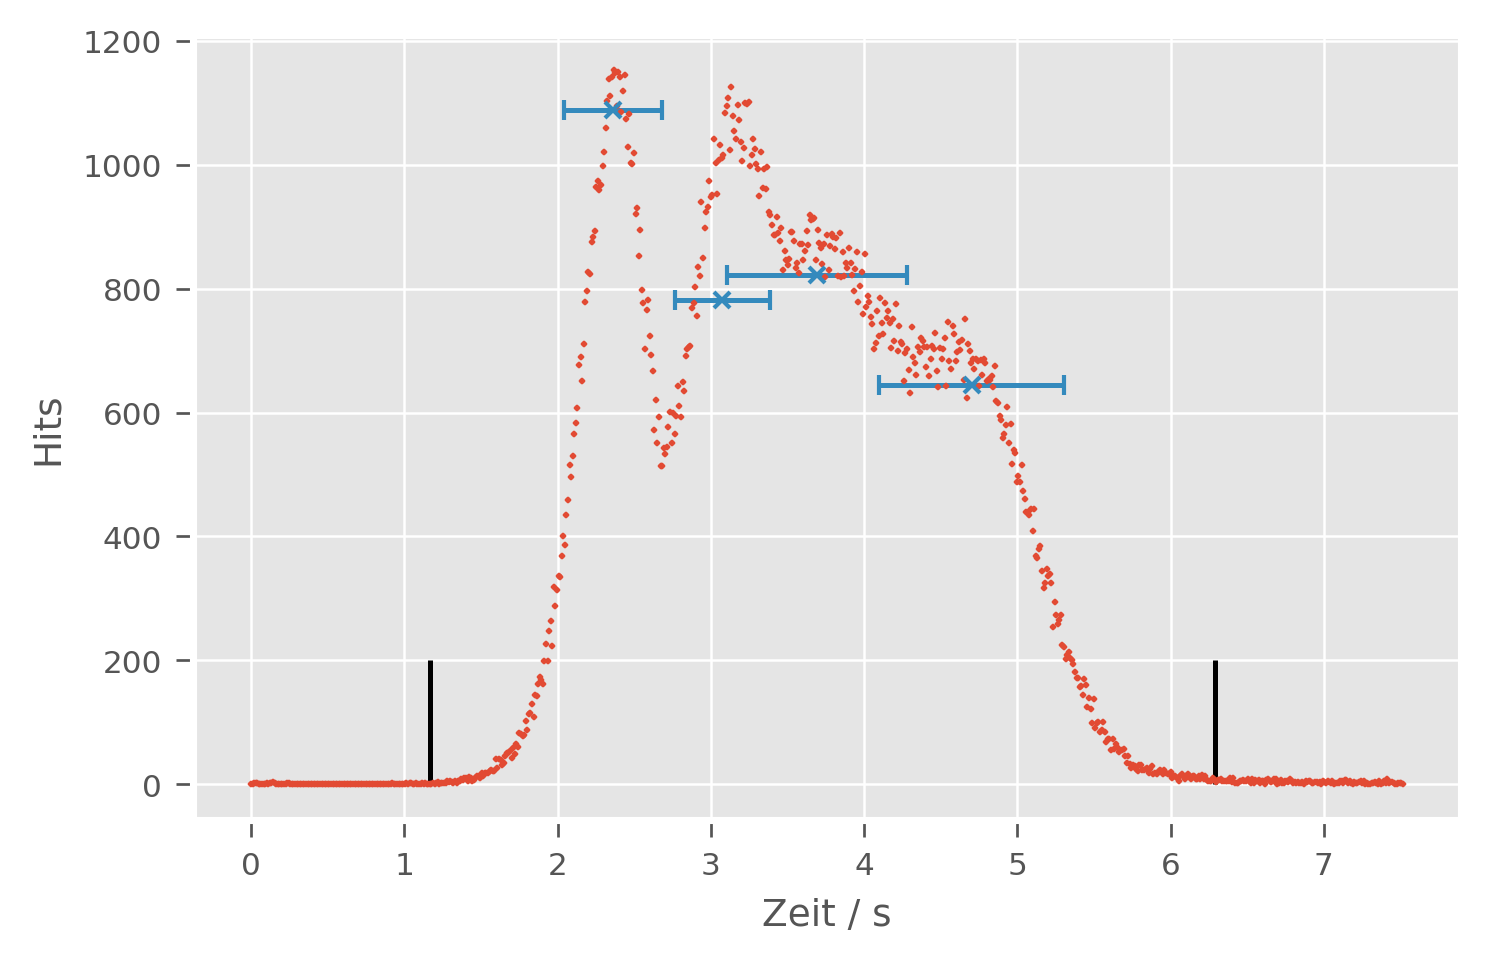

In [31]:
exampleAttr = X.xs(0)
example = readFromTxt([filenames1[0]])[0]
exampleTimes = example[0]
exampleHits = example[2]
peakAmplitudes = [exampleAttr['Peak1Amplitude'], 
                  exampleAttr['Peak2Amplitude'],
                  exampleAttr['Peak3Amplitude'],
                  exampleAttr['Peak4Amplitude']]
peaks = [exampleAttr['Peak1Center'], 
         exampleAttr['Peak2Center'],
         exampleAttr['Peak3Center'],
         exampleAttr['Peak4Center']]
peakwidths = [exampleAttr['Peak1Width'], 
              exampleAttr['Peak2Width'],
              exampleAttr['Peak3Width'],
              exampleAttr['Peak4Width']]

plt.plot(exampleTimes[:-450], exampleHits[:-450], 'x', label='Messwerte',
         markersize=1)
plt.xlabel('Zeit / s')
plt.ylabel('Hits')
plt.vlines(exampleAttr['HeatingStart'] , 0, 200)
plt.vlines(exampleAttr['HeatingEnd'] , 0, 200)
plt.errorbar(peaks,  peakAmplitudes, fmt='x', xerr=peakwidths, markersize=4)
fig = plt.gcf()
fig.set_figheight(3.4)
fig.savefig('./attributeVisualization.pdf')

In [32]:
Y[0]

5.0

In [33]:
filenames1[7]

'../messdaten/calib_data/R1406802_2015-10-15-009.txt'

In [34]:
Yvalues = sorted(Counter(Y).keys())
boxX = [abs(relDiff[Y == Ykey]) for Ykey in Yvalues]
#boxX = {Ykey : relDiff[y_test == Ykey] for Ykey in Yvalues}

In [35]:
len(cpredictions )

1426

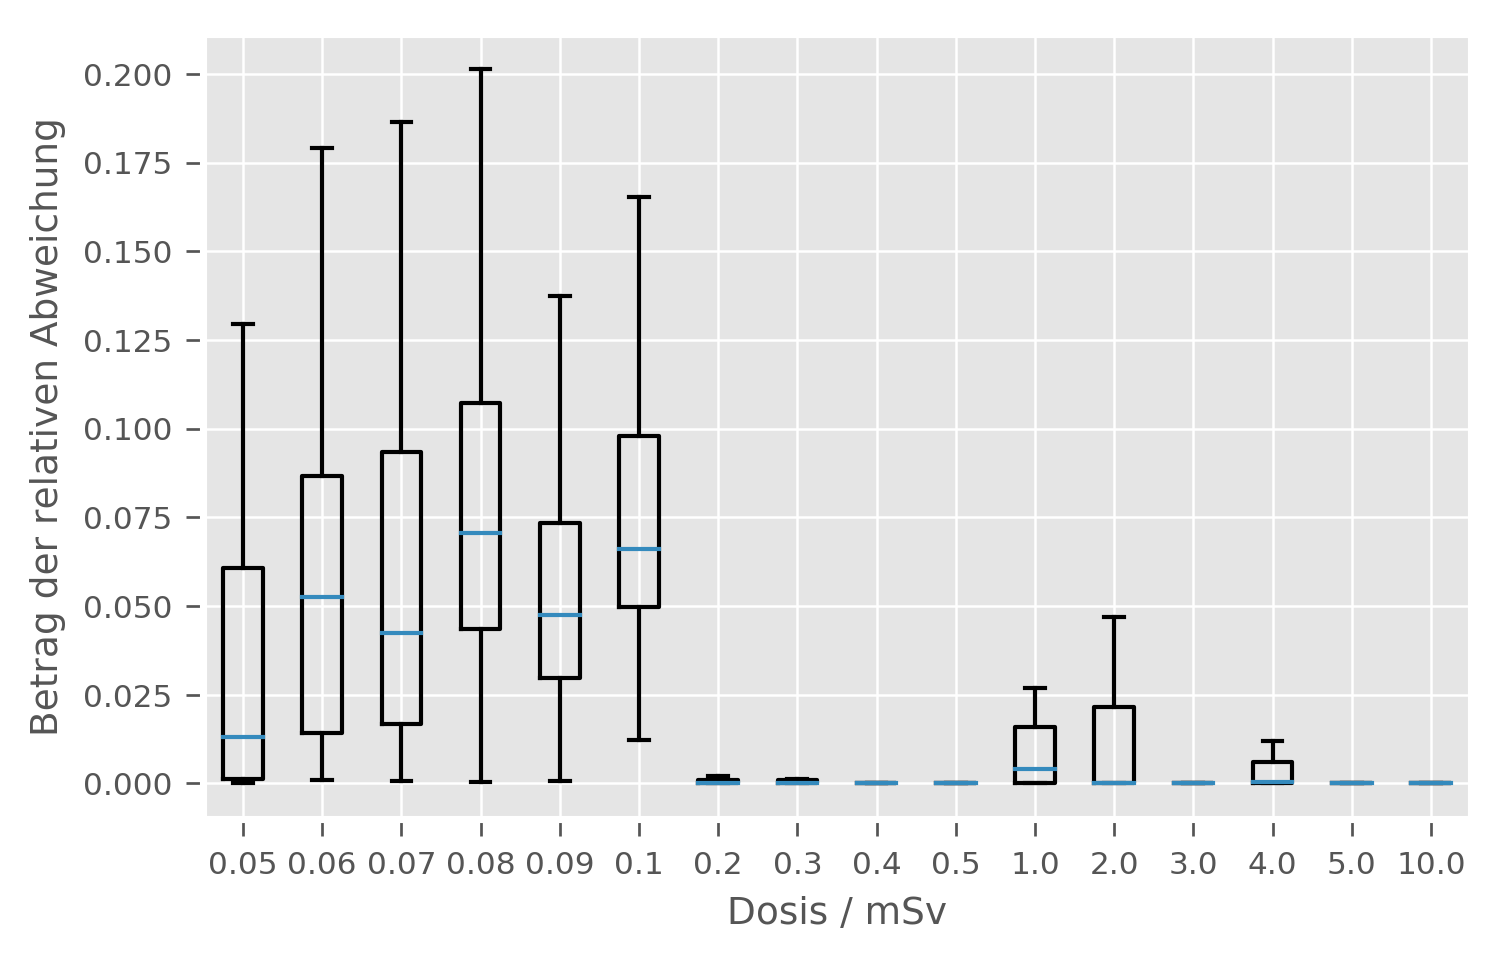

In [36]:
#plt.boxplot(boxX[6:], labels=Yvalues[6:], sym='')
plt.boxplot(boxX, labels=Yvalues, sym='')
plt.xlabel('Dosis / mSv')
plt.ylabel('Betrag der relativen Abweichung')
#plt.ylim(-0.0005, 0.01)
fig = plt.gcf()
fig.set_figheight(3.4)
fig.get_figheight()
fig.savefig('./boxplot.pdf')

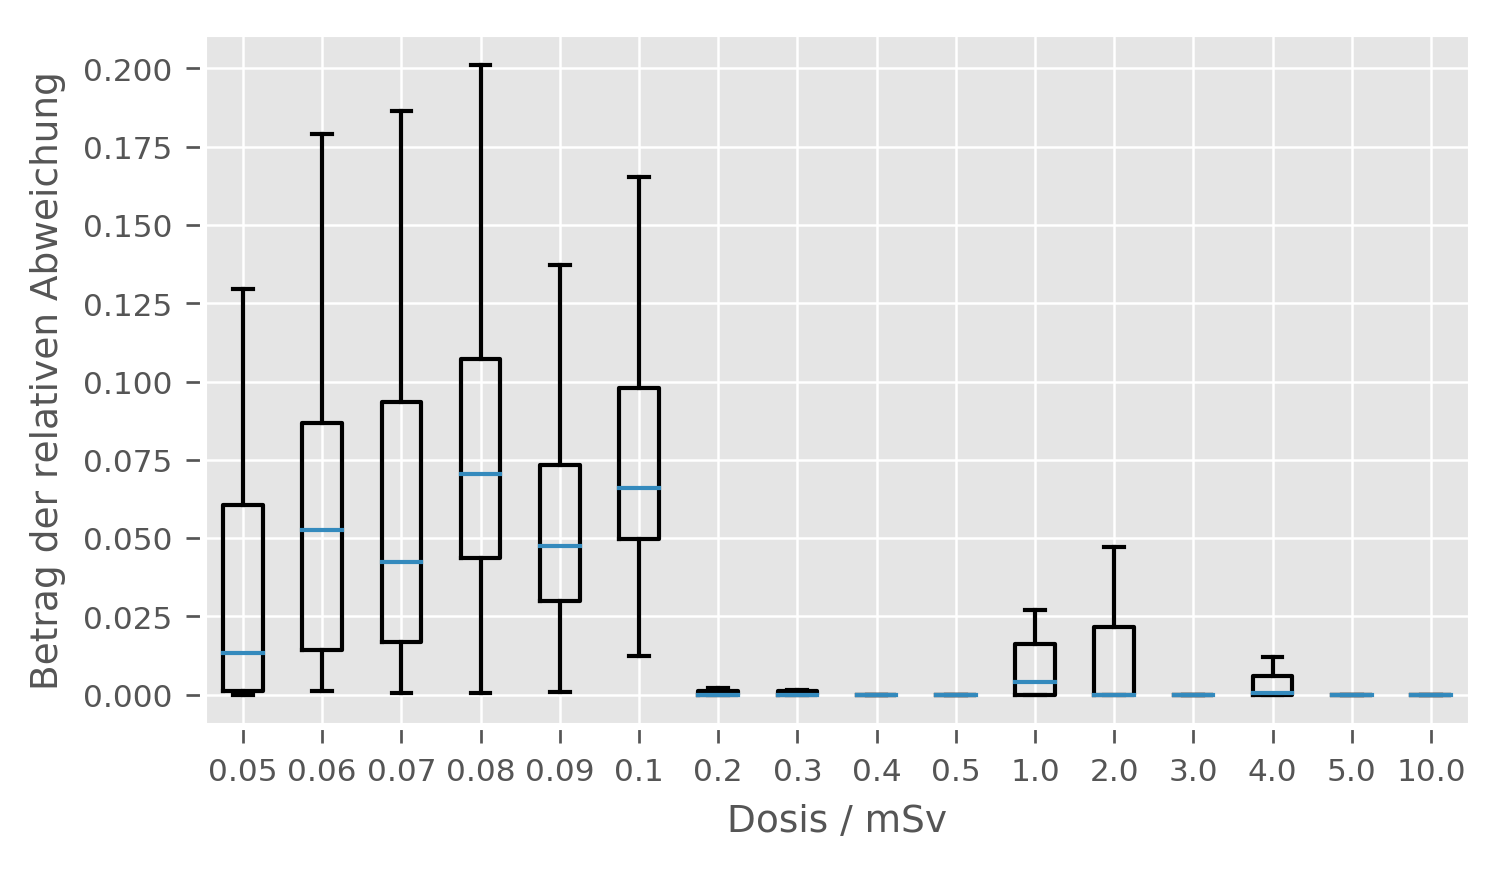

In [37]:
#plt.boxplot(boxX[6:], labels=Yvalues[6:], sym='')
plt.boxplot(boxX, labels=Yvalues, sym='')
plt.xlabel('Dosis / mSv')
plt.ylabel('Betrag der relativen Abweichung')
#plt.ylim(-0.0005, 0.01)
fig = plt.gcf()
#fig.set_figheight(3.8)
fig.get_figheight
fig.savefig('./boxplot3.pdf')

<bound method Figure.get_figheight of <matplotlib.figure.Figure object at 0x7ff066919668>>

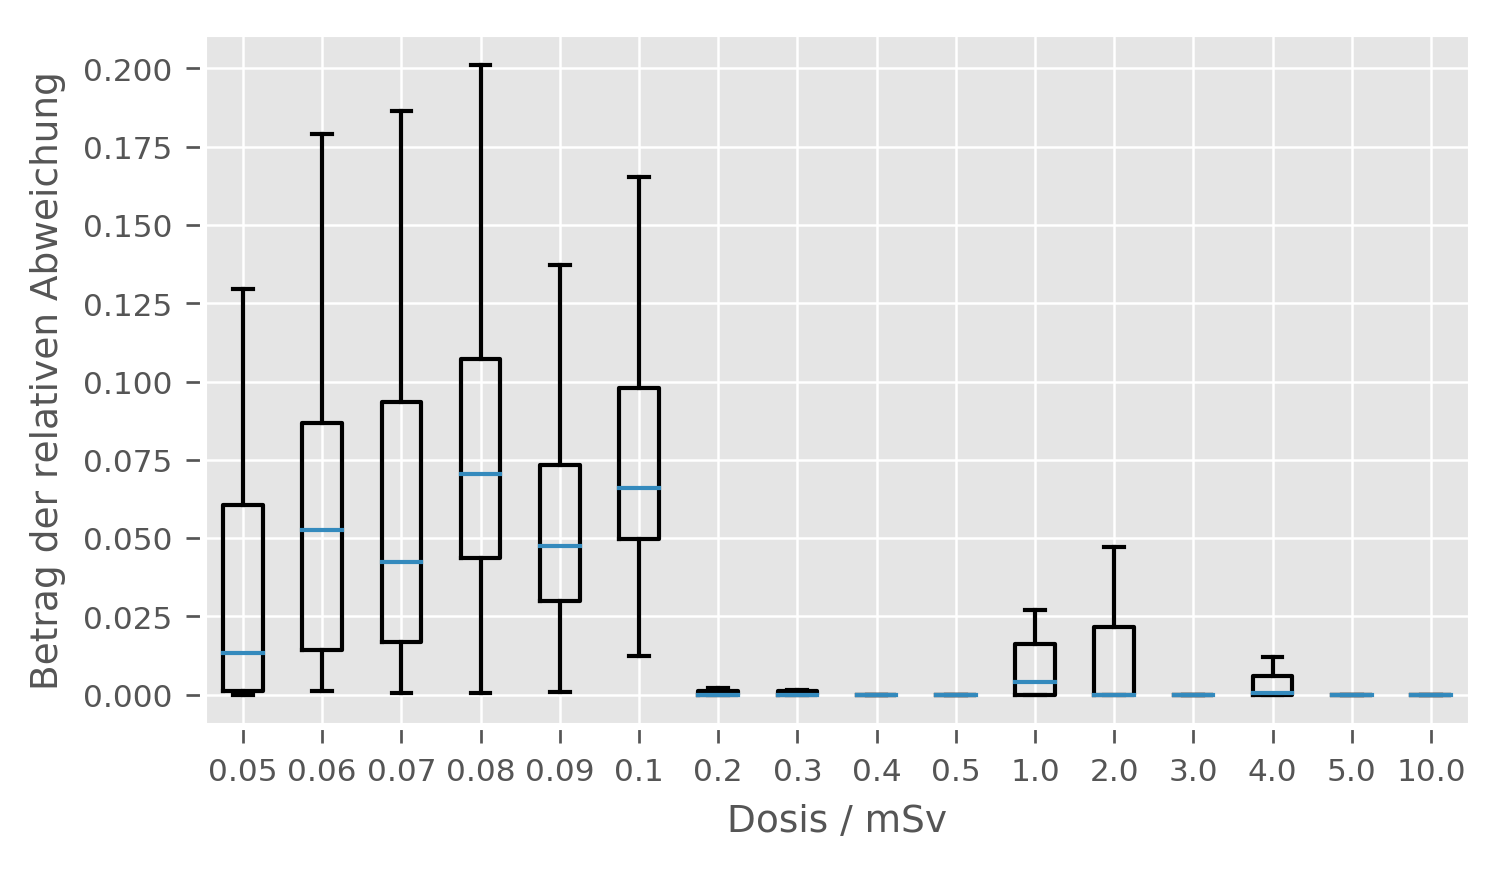

In [38]:
relDiff = ((cpredictions-Y)/Y)
absDiff = ((cpredictions-Y))
absDiff *= 1000
#plt.hist(relDiff, bins=20, range=(-0.2,0.2) )
np.mean(np.abs(relDiff-0.00))
Yvalues = sorted(Counter(Y).keys())
boxX = [abs(relDiff[Y == Ykey]) for Ykey in Yvalues]
#boxX = {Ykey : relDiff[y_test == Ykey] for Ykey in Yvalues}
#plt.boxplot(boxX[6:], labels=Yvalues[6:], sym='')
plt.boxplot(boxX, labels=Yvalues, sym='')
plt.xlabel('Dosis / mSv')
plt.ylabel('Betrag der relativen Abweichung')
#plt.ylim(-0.0005, 0.01)
fig = plt.gcf()
#fig.set_figheight(3.8)
fig.get_figheight
#fig.savefig('./boxplot.pdf')

In [39]:
for i in np.array(boxX):
    print(np.mean(i))

0.0417103448276
0.0735349794239
0.0587125220459
0.0825737179487
0.0612628726287
0.0747421686747
0.0162282352941
0.00571428571429
0.0107554347826
0.000988235294118
0.025
0.0171857142857
0.00809574468085
0.0181373626374
0.00691886792453
0.0034914893617


In [40]:
np.mean(relDiff)*100

0.48110671430814195

In [41]:
np.mean([
0.0393862068966,
0.0702304526749,
0.059188712522,
0.0825673076923,
0.0585501355014,
0.0714289156626,
])

0.063558621824966674

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'str'

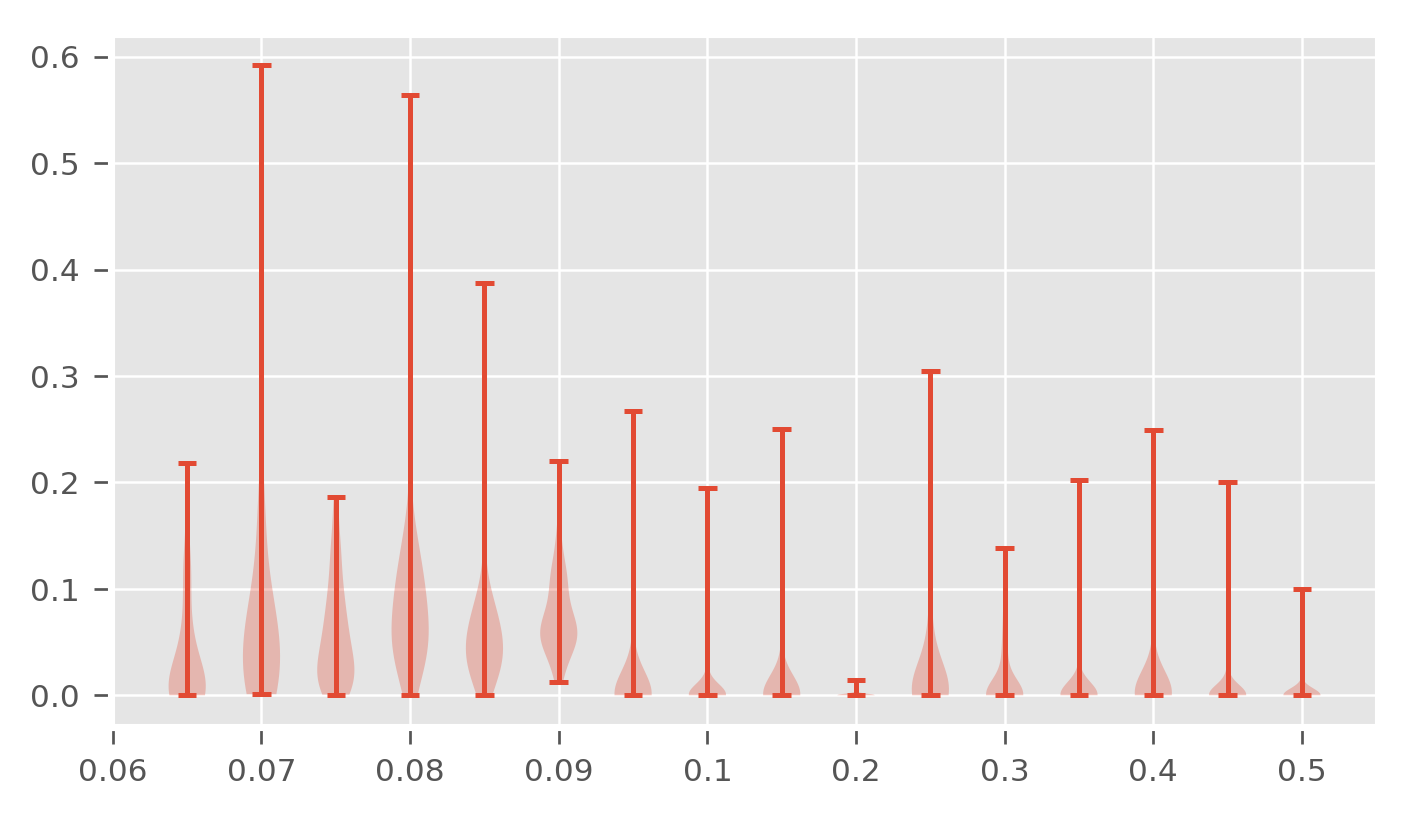

In [42]:
ax = plt.figure()
plt.violinplot(boxX)
zero = ['x']
zero=[]
zero.extend(Yvalues)
zero.append('x')
plt.gca().axes.xaxis.set_ticklabels(zero)
test = plt.gca().axes
test.set_xticks(zero)
xaxis.set_ticklabels(zero)
plt.show()

In [43]:
test = ['0']
test.extend(Yvalues)

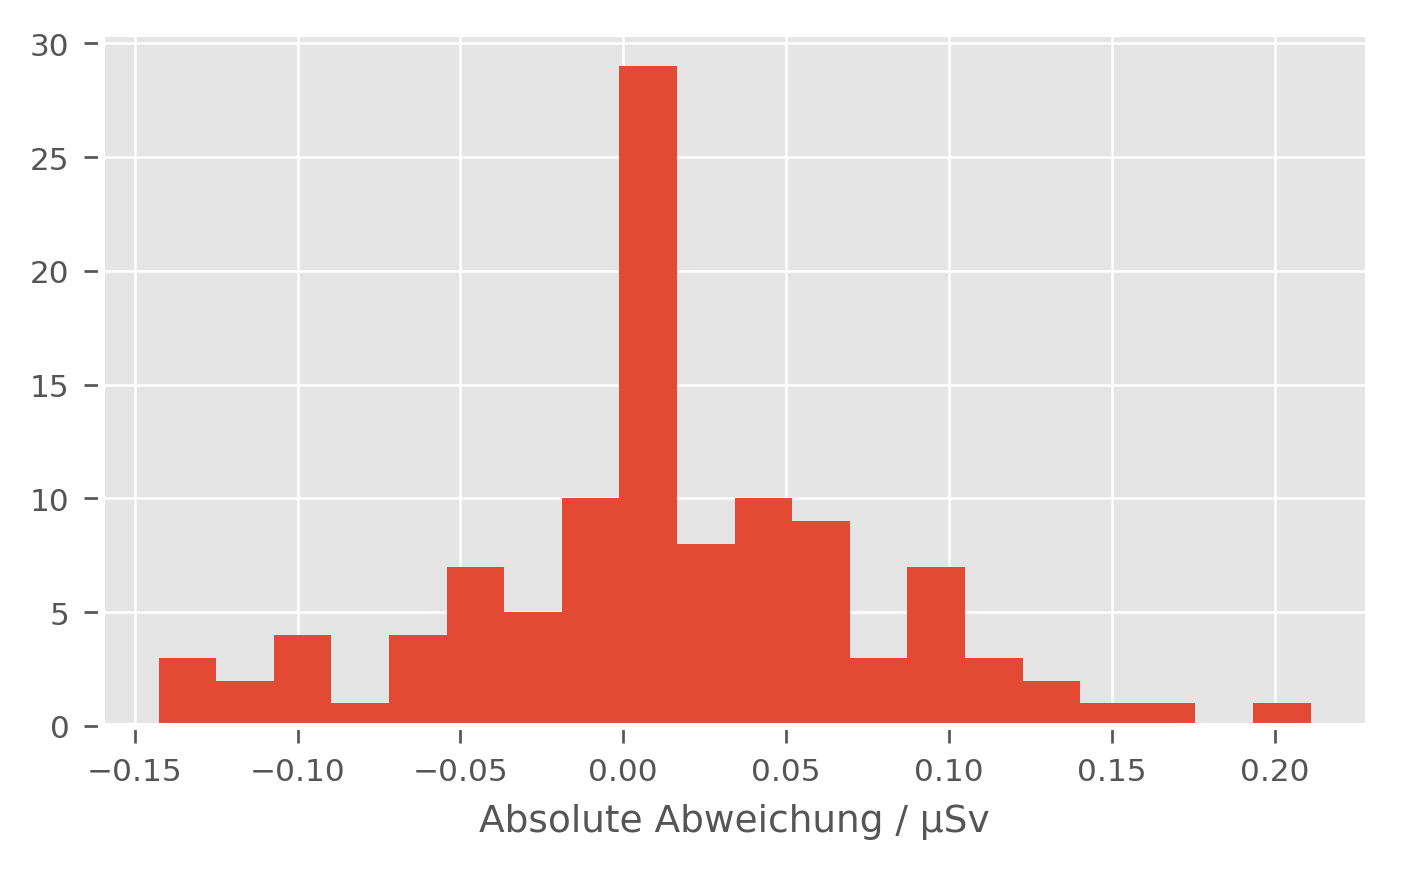

In [44]:
rforestLow = ensemble.RandomForestRegressor(n_estimators=500, criterion='mse', n_jobs=2, )
X_trainLow, X_testLow, y_trainLow, y_testLow = train_test_split(X[Y< 0.25], Y[Y<0.25], 
                                                    test_size=0.2, 
                                                    random_state=0)
rforestLow.fit(X_trainLow, y_trainLow)
predictionsLow = rforestLow.predict(X_testLow)
cpredictionsLow = cross_val_predict(rforestLow, X[Y< 0.25], Y[Y< 0.25], cv=5, n_jobs=2)
relDiff = ((predictionsLow-y_testLow)/y_testLow)
absDiff = ((predictionsLow-y_testLow))
absDiff *= 1000
cRelDiffLow = ((cpredictionsLow-Y[Y< 0.25])/Y[Y< 0.25])
cAbsDiffLow = ((cpredictionsLow-Y[Y< 0.25]))
cAbsDiffLow *= 1000
#plt.hist(relDiff, bins=20, range=(-0.2,0.2) )
plt.hist(relDiff, bins=20)
np.mean(np.abs(relDiff-0.00))
plt.xlabel('Absolute Abweichung / µSv')

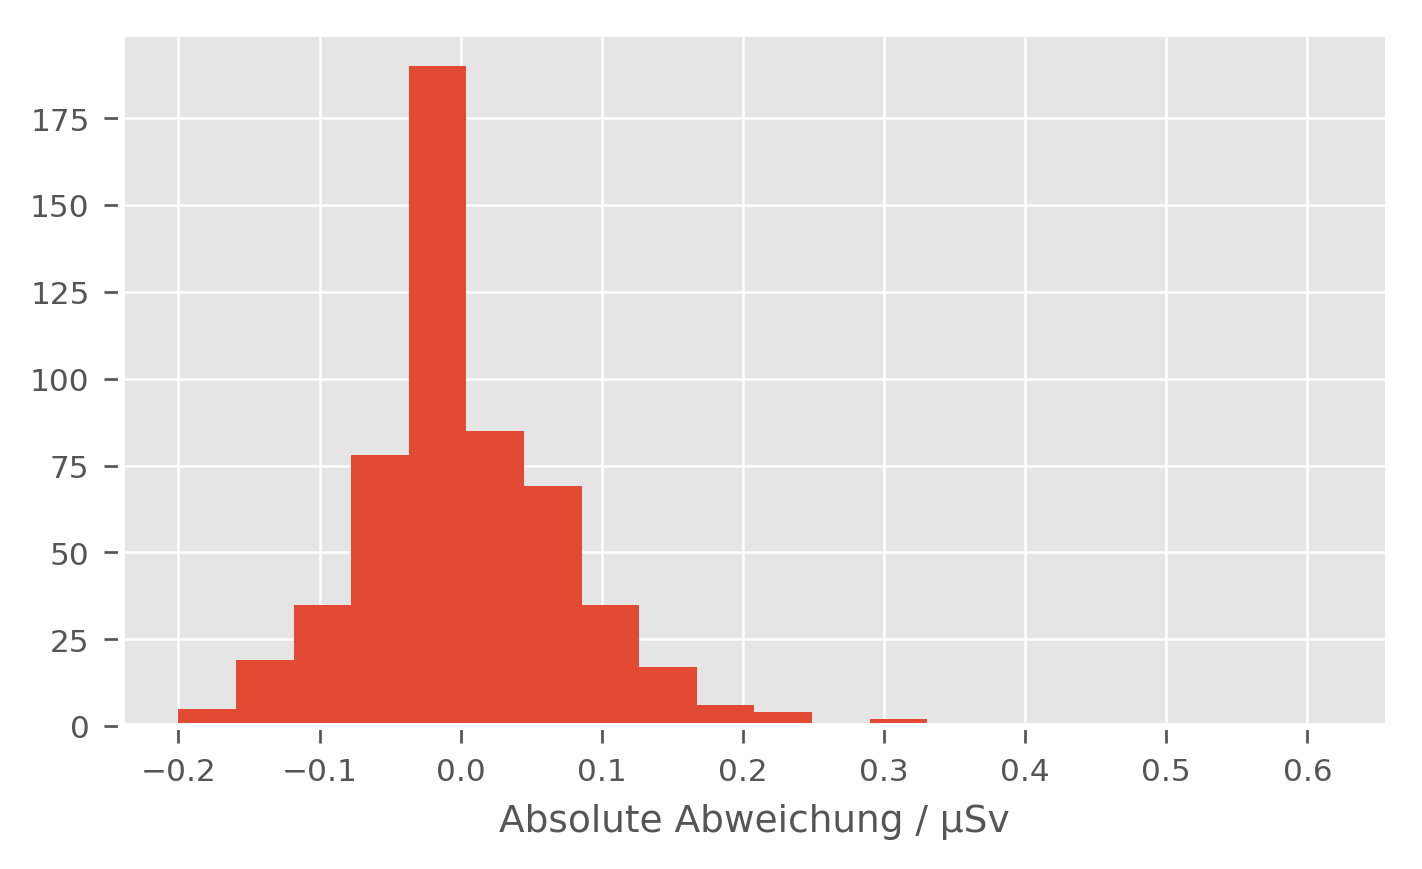

In [45]:
plt.hist(cRelDiffLow, bins=20)
np.mean(np.abs(cRelDiffLow-0.00))
plt.xlabel('Absolute Abweichung / µSv')

In [46]:
rforestLow.score(X_testLow, y_testLow)

0.98696794093312235

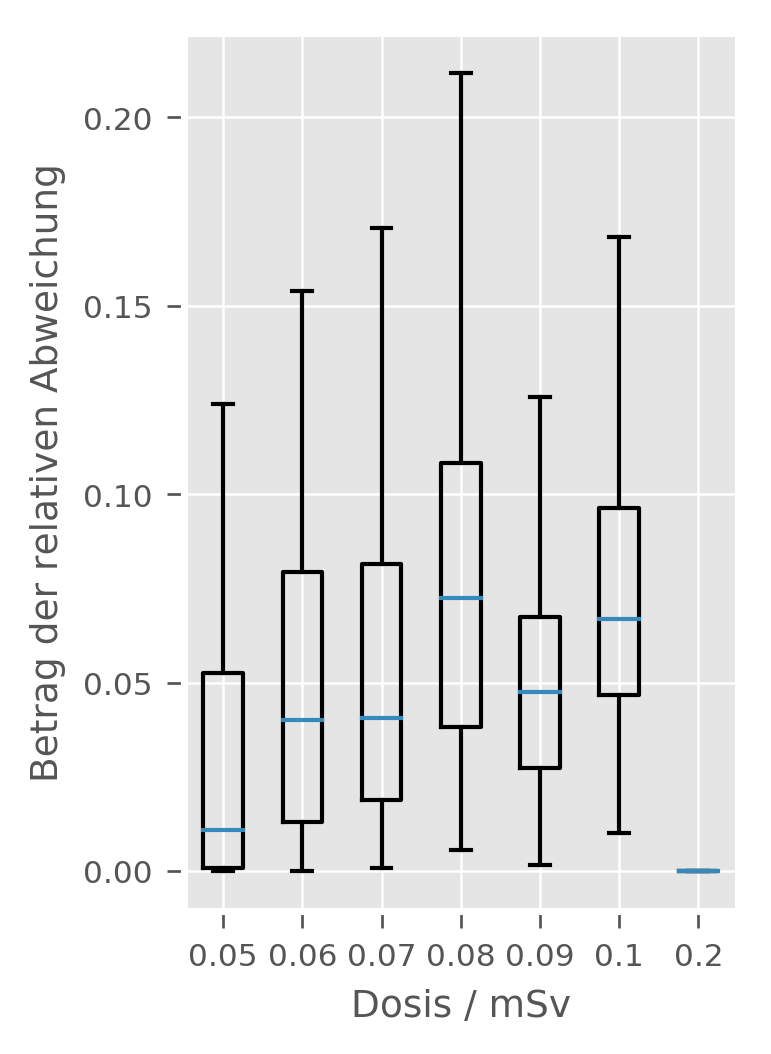

In [47]:
Yvalues = sorted(Counter(y_testLow).keys())
boxX = [abs(cRelDiffLow[Y[Y< 0.25] == Ykey]) for Ykey in Yvalues]
#boxX = {Ykey : relDiff[y_test == Ykey] for Ykey in Yvalues}
boxX
plt.boxplot(boxX, labels=Yvalues, sym='')
plt.xlabel('Dosis / mSv')
plt.ylabel('Betrag der relativen Abweichung')
#plt.ylim(-0.03, 0.2)
fig = plt.gcf()
fig.set_figheight(3.8)
fig.set_figwidth(5.45/2.2857)
fig.savefig('./boxplotSmall.pdf')

In [48]:

for i in np.array(boxX):
    print(np.mean(i))

0.038524137931
0.0595884773663
0.0560388007055
0.0843525641026
0.0542032520325
0.068913253012
0.00856352941177


In [49]:
np.mean([
   0.0384827586207,
0.0587572016461,
0.0564091710758,
0.0832275641026,
0.0534769647697,
0.0684722891566 ,
])

0.059804324895250005

In [55]:
featImp = rforest.feature_importances_
featImp

array([  1.93523362e-06,   3.24044270e-04,   1.86146006e-06,
         1.83398388e-06,   3.59455575e-04,   3.31159788e-06,
         2.40248208e-06,   2.96064892e-03,   3.18301862e-06,
         1.53521288e-06,   3.02276274e-03,   3.23356097e-06,
         4.97613303e-02,   1.26478703e-02,   1.21307238e-05,
         4.06378086e-02,   3.94682382e-03,   3.64400061e-04,
         1.64551411e-05,   9.82940618e-03,   5.10900292e-06,
         4.39029341e-06,   2.14534868e-01,   1.55133248e-01,
         6.05668052e-05,   6.74517315e-05,   0.00000000e+00,
         1.18702085e-02,   2.37028583e-01,   2.32487997e-01,
         4.82999834e-05,   3.98789031e-05,   2.48169648e-02])

In [56]:
features = np.array(X.columns).astype(str)


In [57]:
for col, i in zip(features.tolist(), featImp.tolist()):
    print(col, i)

Peak1Center 1.9352336170932236e-06
Peak1Amplitude 0.00032404427028185284
Peak1Width 1.8614600579182868e-06
Peak2Center 1.8339838771401818e-06
Peak2Amplitude 0.0003594555745121344
Peak2Width 3.3115978800373704e-06
Peak3Center 2.4024820751303306e-06
Peak3Amplitude 0.0029606489239719846
Peak3Width 3.1830186221062216e-06
Peak4Center 1.5352128761016641e-06
Peak4Amplitude 0.0030227627385053814
Peak4Width 3.2335609728046484e-06
Peak1AreaRaw 0.049761330254194866
Peak2AreaRaw 0.012647870324249183
Peak3AreaRaw 1.2130723795332577e-05
Peak4AreaRaw 0.040637808566959796
Peak1AreaFit 0.00394682381680692
Peak2AreaFit 0.00036440006119078326
Peak3AreaFit 1.645514111492258e-05
Peak4AreaFit 0.009829406177207435
HeatingStart 5.1090029248957515e-06
HeatingEnd 4.390293406923078e-06
TotalHitsRaw 0.21453486802211486
TotalHitsFit 0.15513324846424376
HitsPreHeatingFirstRaw 6.0566805177459296e-05
HitsPreHeatingSecondRaw 6.745173154816727e-05
HitsPostHeatingFirstRaw 0.0
HistPostHeatingSecondRaw 0.01187020845434990

In [58]:
from sklearn.svm import SVR

ss = np.sort(5 * np.random.rand(40, 1), axis=0)


svr_rbf = SVR(kernel='rbf', C=1e4, gamma=0.2)
#svr_lin = SVR(kernel='linear', C=1e3)
#svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = cross_val_predict(svr_rbf, X, Y, cv=5, n_jobs=2)
#y_lin = svr_lin.fit(X, Y).predict(X)
#y_poly = svr_poly.fit(X, Y).predict(X)

lw = 2
#plt.scatter(X, Y, color='darkorange', label='data')
#plt.hold('on')
#plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
#plt.plot(X, y_lin, color='c', lw=lw, label='Linear model')
#plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
#plt.xlabel('data')
#plt.ylabel('target')
#plt.title('Support Vector Regression')

In [59]:
y_rbf

array([ 2.01566123,  2.01566123,  2.01566123, ...,  2.08916893,
        2.08916893,  2.08916893])

<bound method Figure.get_figheight of <matplotlib.figure.Figure object at 0x7ff0681b45f8>>

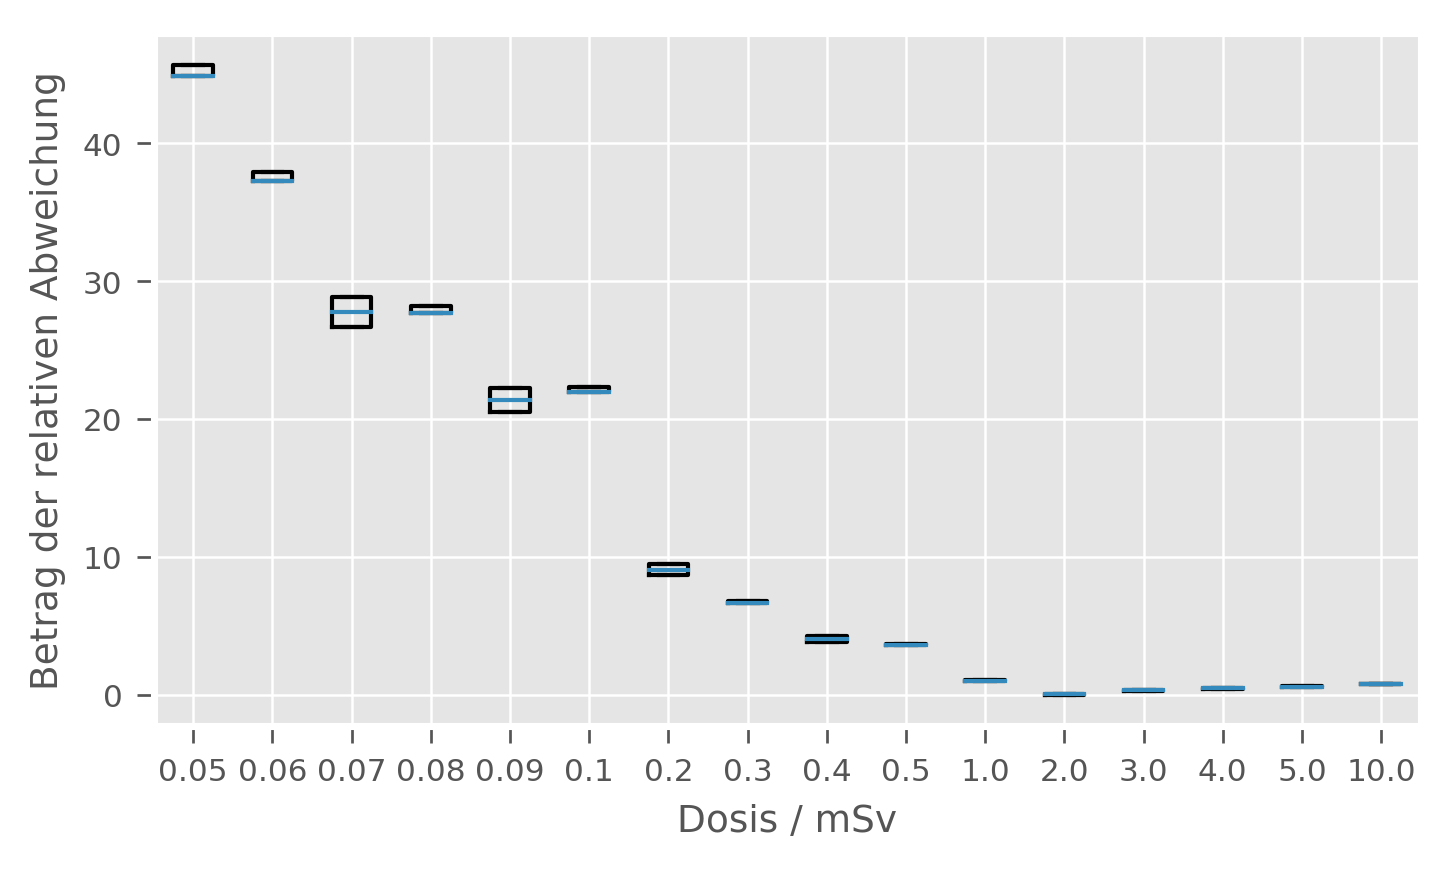

In [60]:

relDiff = ((y_rbf-Y)/Y)
absDiff = ((y_rbf-Y))
absDiff *= 1000
#plt.hist(relDiff, bins=20, range=(-0.2,0.2) )
np.mean(np.abs(relDiff-0.00))
Yvalues = sorted(Counter(Y).keys())
boxX = [abs(relDiff[Y == Ykey]) for Ykey in Yvalues]
#boxX = {Ykey : relDiff[y_test == Ykey] for Ykey in Yvalues}
#plt.boxplot(boxX[6:], labels=Yvalues[6:], sym='')
plt.boxplot(boxX, labels=Yvalues, sym='')
plt.xlabel('Dosis / mSv')
plt.ylabel('Betrag der relativen Abweichung')
#plt.ylim(-0.0005, 0.01)
fig = plt.gcf()
#fig.set_figheight(3.8)
fig.get_figheight
#fig.savefig('./boxplot.pdf')

In [61]:
useful = ['Peak1Amplitude', 'Peak2Amplitude', 
 'Peak3Amplitude', 'Peak4Amplitude',
 'Peak1AreaRaw', 'Peak2AreaRaw',
 'Peak3AreaRaw', 'Peak4AreaRaw',
 'HeatingStart',  'TotalHitsRaw',
 'MeanHitsPreHeatingRaw',
 'MeanHitsPostHeatingRaw']


In [62]:
noise = np.random.normal(0, 0.003, len(Y[Y<0.2]))

/home/fongo/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


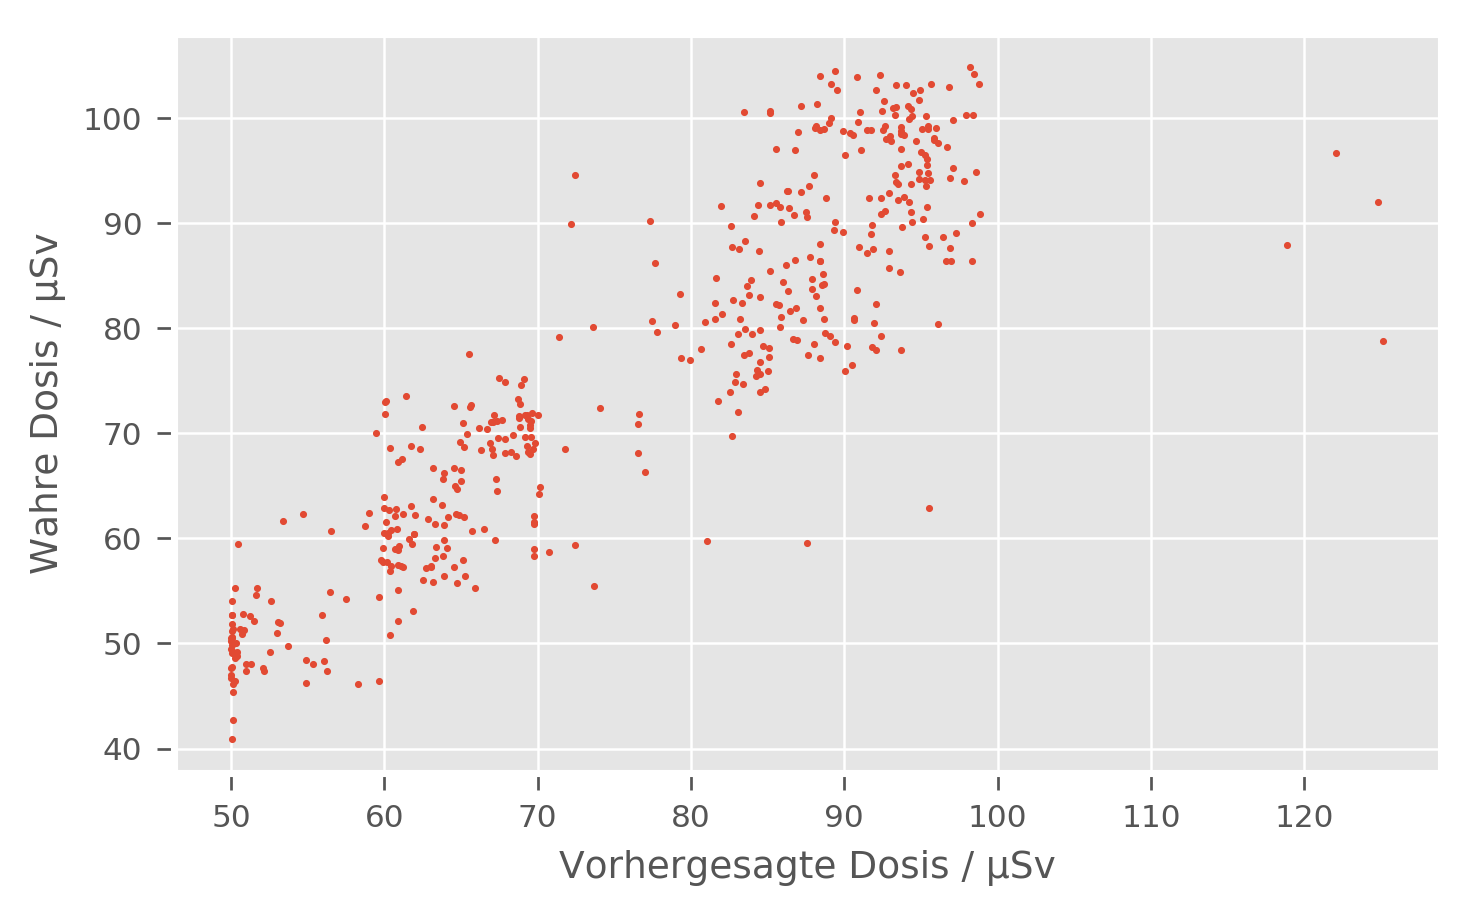

In [63]:
plt.scatter(cpredictions[Y<0.2]*1000, (Y[Y < 0.2]+noise)*1000, s=1)
#plt.hist2d(cpredictions[Y<0.2], Y[Y < 0.2])
plt.legend()
plt.xlabel('Vorhergesagte Dosis / µSv')
plt.ylabel('Wahre Dosis / µSv')
#plt.xlim(0.05, 0.11)
fig = plt.gcf()
fig.set_figheight(3.2)
fig.get_figheight
plt.savefig('./scatter.pdf')

/home/fongo/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


<bound method Figure.get_figheight of <matplotlib.figure.Figure object at 0x7ff06862b128>>

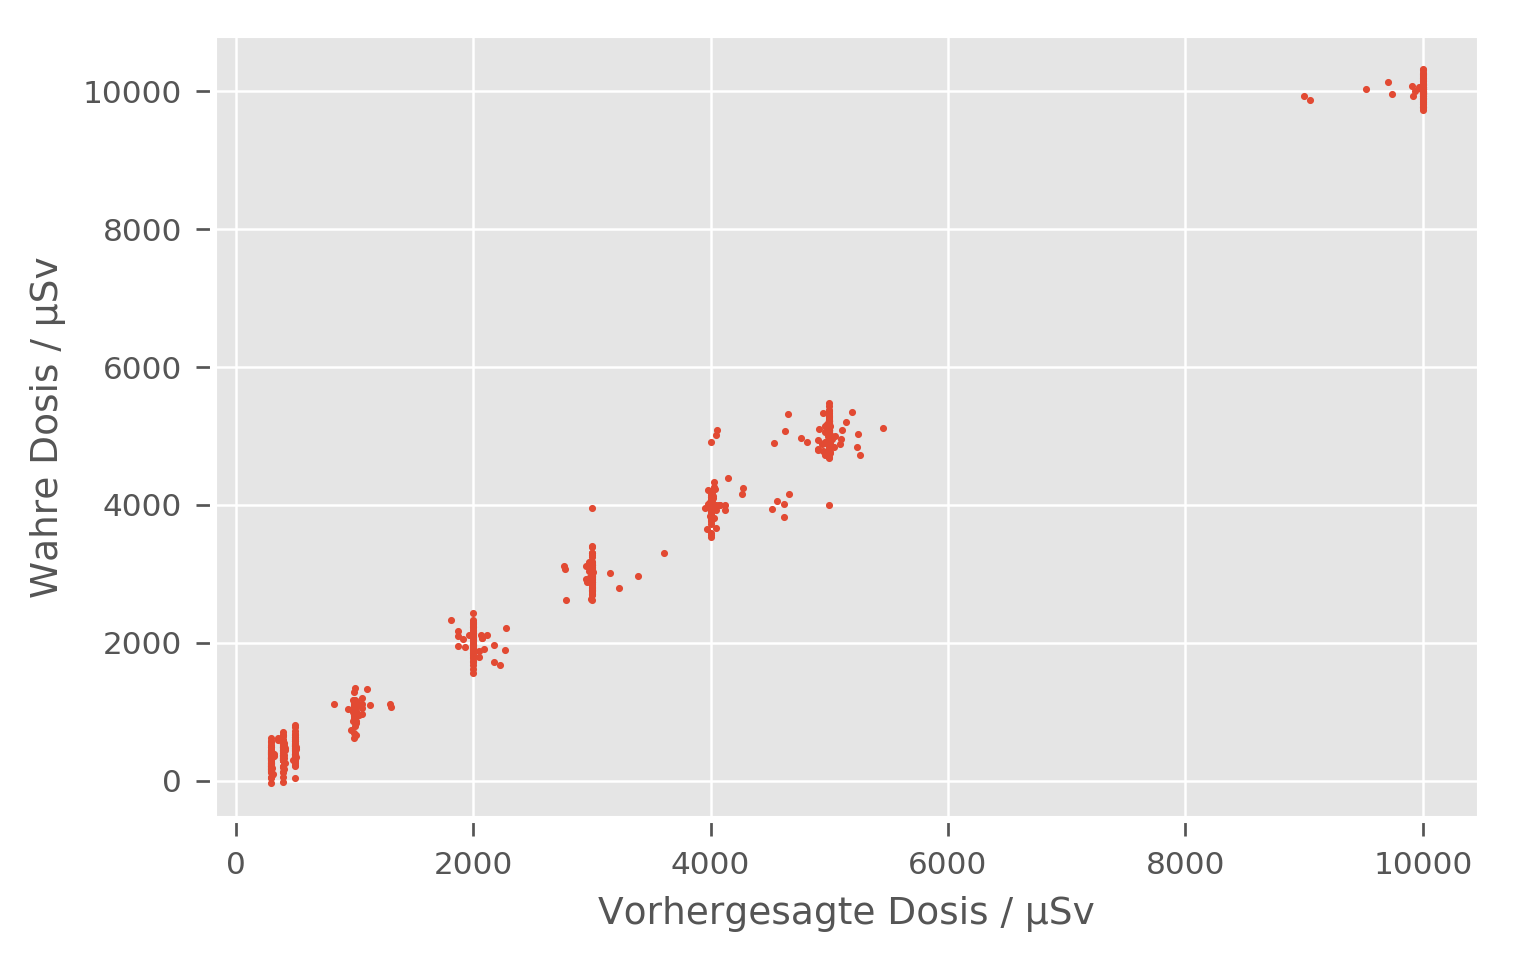

In [64]:
noise2 = np.random.normal(0, 0.15, len(Y[Y>0.2]))
plt.scatter(cpredictions[Y>0.2]*1000, (Y[Y > 0.2]+noise2)*1000, s=1)
#plt.hist2d(cpredictions[Y<0.2], Y[Y < 0.2])
plt.legend()
plt.xlabel('Vorhergesagte Dosis / µSv')
plt.ylabel('Wahre Dosis / µSv')
#plt.xlim(0.05, 0.11)
fig = plt.gcf()
fig.set_figheight(3.4)
fig.get_figheight
#plt.savefig('./scatter.pdf')